# Part I: Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from joblib import Parallel, delayed
import random
import os
import time

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(0)

import warnings
warnings.filterwarnings("ignore")

# Part II: AUC Objects

In [2]:
# Credits to Shusen Wang @ https://wangshusen.github.io/code/countsketch.html
def countSketchInMemroy(matrixA, s):
    m, n = matrixA.shape
    matrixC = np.zeros([m, s])
    hashedIndices = np.random.choice(s, n, replace=True)
    randSigns = np.random.choice(2, n, replace=True) * 2 - 1 # a n-by-1{+1, -1} vector
    matrixA = matrixA * randSigns.reshape(1, n) # flip the signs of 50% columns of A
    for i in range(s):
        idx = (hashedIndices == i)
        matrixC[:, i] = np.sum(matrixA[:, idx], 1)
    return matrixC.T

In [240]:
class AUC:
    def __init__(self, A, lamb):
        """
        A: Raw dataset, with last column denotes labels
        lamb: regularization coefficient for each data point
        """
        d = A.shape[1]                               # d denotes the total number of columns of input 
        A0 = A[:, :d - 1]                            # Local observations with features
        b = A[:, d - 1]                              # Local observations' labels
        Ap = A0[b == 1]                              # Local observations with positive labels
        An = A0[b == 0]                              # Local observations with negative labels
        n_p = Ap.shape[0]                            # Number of local positive observations
        n_n = An.shape[0]                            # Number of local negative observations

        self.A = A
        self.A0 = A0
        self.Ap = Ap
        self.An = An
        self.nn = n_n
        self.np = n_p
        self.n = n_n + n_p                           # Number of local observations
        self.dim = d - 1                             # dimension of w (z = [w, u, v, y])

        
        if A.shape[1] == 124:                        # a9a
            self.p = 7841 / 32561
        elif A.shape[1] == 301:                      # w8a
            self.p = 1320 / 45546
        elif A.shape[1] == 4933:                     # sido0
            self.p = 452 / 12678
        
        self.lamb = lamb                             # regularization coefficient
        
        
        self.H_wu = -2 * (1 - self.p) * np.sum(self.Ap, axis=0).reshape(-1, 1) / self.n
        self.H_wv = -2 * self.p * np.sum(self.An, axis=0).reshape(-1, 1) / self.n
        self.H_wy = -2 * (1 - self.p) * np.sum(self.Ap, axis=0).reshape(-1, 1) / self.n + 2 * self.p * np.sum(self.An, axis=0).reshape(-1, 1) / self.n
        
        self.H_uu = self.lamb + 2 * (1 - self.p) * self.np / self.n
        self.H_vv = self.lamb + 2 * self.p * self.nn / self.n
        self.H_yy = -2 * self.p * (1 - self.p)
    
    
    def grad(self, z):
        # z = [w, u, v, y]
        w, u, v, y = z[:self.dim], z[self.dim], z[self.dim+1], z[self.dim+2]
        
        gw = self.lamb * w + 2 * (1 - self.p) * self.Ap.T @ (self.Ap @ w - u - 1 - y) / self.n + 2 * self.p * self.An.T @ (self.An @ w - v + 1 + y) / self.n
        
        gu = self.lamb * u - 2 * (1 - self.p) * np.sum(self.Ap @ w - u) / self.n

        gv = self.lamb * v - 2 * self.p * np.sum(self.An @ w - v) / self.n
        
        gy = -2 * self.p * (1 - self.p) * y + 2 * self.p * np.sum(self.An @ w) / self.n - 2 * (1 - self.p) * np.sum(self.Ap @ w) / self.n
        
        gz = np.zeros(self.dim + 3)
        gz[:self.dim] = gw.flatten()
        gz[self.dim] = gu
        gz[self.dim + 1] = gv
        gz[self.dim + 2] = gy
        
        return gz.astype('double').reshape(-1, 1)
    
    @property
    def Hxy(self):
        # x = [w, u, v], H_{uy} = H_{vy} = 0
        H_xy = np.vstack([self.H_wy, np.zeros(2).reshape(-1, 1)])
        return H_xy.astype('double')
        
    @property
    def Hyy(self):
        return np.array(self.H_yy).reshape(-1, 1).astype('double')
    
    @property
    def Hxx(self):
        H_ww = self.lamb * np.eye(self.dim) + 2 * (1 - self.p) * (self.Ap.T @ self.Ap) / self.n + 2 * self.p * (self.An.T @ self.An) / self.n
        H_uw = self.H_wu.T
        H_vw = self.H_wv.T
        
        H_xx = np.zeros((self.dim + 2, self.dim + 2))
        H_xx[:self.dim, :self.dim] = H_ww
        H_xx[self.dim, self.dim] = self.H_uu
        H_xx[self.dim + 1, self.dim + 1] = self.H_vv
        H_xx[:self.dim, self.dim] = self.H_wu.reshape(-1)
        H_xx[:self.dim, self.dim + 1] = self.H_wv.reshape(-1)
        H_xx[self.dim, :self.dim] = H_uw.reshape(-1)
        H_xx[self.dim + 1, :self.dim] = H_vw.reshape(-1)
        
        return H_xx.astype('double')

In [241]:
class AUC_Sketch(AUC):
    def __init__(self, A, lamb, method='uniform', pct=0.1):
        super().__init__(A, lamb)
        self.method = method
        self.pct = pct
        self.sketch_size = int(self.pct * self.A.shape[0])

        A0_aug = np.hstack((np.copy(self.A0), np.zeros((self.n, 2))))
        A0_aug[self.A[:, -1] == 1, -2] = -1
        A0_aug[self.A[:, -1] == 0, -1] = -1
        A0_aug[self.A[:, -1] == 1] = np.sqrt(2 * (1 - self.p)) * A0_aug[self.A[:, -1] == 1]
        A0_aug[self.A[:, -1] == 0] = np.sqrt(2 * self.p) * A0_aug[self.A[:, -1] == 0]
        self.A0_aug = A0_aug
    
    @property
    def Hxx(self):
        if self.method == 'uniform':
            selected = np.random.choice(range(self.n), self.sketch_size, replace=False)
            return self.A0_aug[selected].T @ self.A0_aug[selected] / self.sketch_size + self.lamb * np.identity(self.dim+2)
        
        elif self.method == 'gaussian':
            S = np.random.normal(loc=0.0, scale=1/np.sqrt(self.sketch_size), size=(self.sketch_size, self.n))
            SA = S @ self.A0_aug
            return SA.T @ SA / self.sketch_size + self.lamb * np.identity(self.dim+2)

        elif self.method == 'count':
            S = countSketchInMemroy(self.A0_aug, self.sketch_size)
            SA = S @ self.A0_aug
            return SA.T @ SA / self.sketch_size + self.lamb * np.identity(self.dim+2)

# Part III: PAN Framework

In [5]:
def PAN(params, A, lamb, ratio=0.1, epochs=100, lr=1.0):
    gradients = []
    obj = AUC(A, lamb)
    init_grad = np.linalg.norm(obj.grad(params), ord=2)
    gradients.append(init_grad)
    cpu_time = [0.0]
    print(f'epoch {0}, gradient norm: {init_grad}')
    
    A_sampled = A[np.random.choice(range(A.shape[0]), size=int(ratio * A.shape[0]), replace=False)]
    local_obj = AUC(A_sampled, lamb)
    
    for num_epoch in range(1, epochs+1):
        start_time = time.time()
        
        gz = obj.grad(params)
        gx, gy = gz[:-1].reshape(-1, 1), gz[-1].reshape(-1, 1)
        Hxy = obj.Hxy
        Hyy = obj.Hyy
        Hxx = local_obj.Hxx
        Hxx_inv = np.linalg.inv(Hxx)
        Hyy_inv = np.linalg.inv(Hyy)
        
        G2 = Hyy - Hxy.T @ Hxx_inv @ Hxy
        G2_inv = np.linalg.inv(G2)
        G1_inv = Hxx_inv + (Hxx_inv @ Hxy) @ np.linalg.inv(G2) @ (Hxx_inv @ Hxy).T
        
        dx = G1_inv @ (gx - Hxy @ Hyy_inv @ gy)
        dy = G2_inv @ gy - Hyy_inv @ Hxy.T @ G1_inv @ gx
        d = np.vstack([dx, dy])
        
        params -= lr * d
        
        end_time = time.time()
        cpu_time.append(end_time - start_time)
        
        grad_norm = np.linalg.norm(obj.grad(params), ord=2)
        gradients.append(grad_norm)
        if num_epoch % 5 == 0:
            print(f'epoch {num_epoch}, gradient norm: {grad_norm}')
    
    return params, gradients, cpu_time

# Part IV: PANDA Algorithm

In [6]:
def PANDA(params, A, lamb, n_workers=8, epochs=100, lr=1.0):
    gradients = []
    cpu_time = [0.0]
    N = A.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    data_blocks = np.array_split(indices, n_workers)
    local_obj = [AUC(A[data_blocks[i]], lamb) for i in range(n_workers)]
    init_grad = np.linalg.norm(np.mean([obj.grad(params) for obj in local_obj], axis=0), ord=2)
    gradients.append(init_grad)
    print(f'epoch {0}, gradient norm: {init_grad}')
    
    for num_epoch in range(1, epochs+1):
        time_count = 0.0
        g_xi, g_yi, H_xyi, H_yyi = [], [], [], []
        
        def parallel_mission1(worker_idx):
            obj = local_obj[worker_idx]
            gz = obj.grad(np.copy(params))
            gx, gy = gz[:-1].reshape(-1, 1), gz[-1].reshape(-1, 1)
            H_xy, H_yy = obj.Hxy, obj.Hyy
            g_xi.append(gx); g_yi.append(gy)
            H_xyi.append(H_xy); H_yyi.append(H_yy)
            return None
        
        local_start1 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission1)(i) 
                                                 for i in range(n_workers))
        local_end1 = time.time()
        time_count += (local_end1 - local_start1) / n_workers
        
        server_start1 = time.time()
        g_x = np.mean(g_xi, axis=0).reshape(-1, 1)
        g_y = np.mean(g_yi, axis=0).reshape(-1, 1)
        H_xy = np.mean(H_xyi, axis=0).reshape(-1, 1)
        H_yy = np.mean(H_yyi, axis=0).reshape(-1, 1)
        server_end1 = time.time()
        time_count += (server_end1 - server_start1)
        
        pxi, pxyi = [], []
        def parallel_mission2(worker_idx):
            obj = local_obj[worker_idx]
            Hxx_inv = np.linalg.inv(obj.Hxx)
            px = Hxx_inv @ g_x; pxy = Hxx_inv @ H_xy
            pxi.append(px); pxyi.append(pxy)
            return None
        
        local_start2 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission2)(i) 
                                                 for i in range(n_workers))
        local_end2 = time.time()
        time_count += (local_end2 - local_start2) / n_workers
        
        
        server_start2 = time.time()
        p_xy = np.mean(pxyi, axis=0)
        p_x = np.mean(pxi, axis=0)

        C2 = H_yy - H_xy.T @ p_xy
        C2_inv = np.linalg.inv(C2)
        C1_inv_g_x = p_x + p_xy @ C2_inv @ H_xy.T @ p_x
        C1_inv_H_xy_H_yy_inv = p_xy @ np.linalg.inv(H_yy) + p_xy @ C2_inv @ H_xy.T @ p_xy @ np.linalg.inv(H_yy)
        
        d_x = C1_inv_g_x - C1_inv_H_xy_H_yy_inv @ g_y
        d_y = C2_inv @ g_y - np.linalg.inv(H_yy) @ H_xy.T @ C1_inv_g_x
        
        d = np.vstack([d_x, d_y])
        params = params - lr * d
        server_end2 = time.time()
        time_count += (server_end2 - server_start2)
        
        cpu_time.append(time_count)

        grad_norm = np.linalg.norm(np.mean([obj.grad(params) for obj in local_obj], axis=0), ord=2)
        gradients.append(grad_norm)
        if num_epoch % 5 == 0:
            print(f'epoch {num_epoch}, gradient norm: {grad_norm}')
        
    return params, gradients, cpu_time

# Part V: Extra Gradient & ProxSkip-VI-FL Algorithms

In [7]:
def parallel_extra(params, A, lamb, n_workers=8, epochs=30, lr=0.8):
    gradients = []
    cpu_time = [0.0]
    N = A.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    data_blocks = np.array_split(indices, n_workers)
    local_obj = [AUC(A[data_blocks[i]], lamb) for i in range(n_workers)]
    init_grad = np.linalg.norm(np.mean([obj.grad(params) for obj in local_obj], axis=0), ord=2)
    gradients.append(init_grad)
    print(f'epoch {0}, gradient norm: {init_grad}')
    
    for num_epoch in range(1, epochs+1):
        time_count = 0.0
        g_xi, g_yi = [], []
        def parallel_mission1(worker_idx):
            obj = local_obj[worker_idx]
            gz = obj.grad(params)
            gx, gy = gz[:-1].reshape(-1, 1), gz[-1].reshape(-1, 1)
            g_xi.append(gx)
            g_yi.append(gy)
            return None

        local_start1 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission1)(i) 
                                              for i in range(n_workers))
        local_end1 = time.time()
        time_count += (local_end1 - local_start1) / n_workers
        
        server_start1 = time.time()
        g_x = np.mean(g_xi, axis=0)
        g_y = np.mean(g_yi, axis=0)
        server_end1 = time.time()
        time_count += (server_end1 - server_start1)

        
        server_start2 = time.time()
        params_temp = np.copy(params)
        params_temp[:-1] -= lr * g_x
        params_temp[-1] += lr * g_y.flatten()
        server_end2 = time.time()
        time_count += (server_end2 - server_start2)
        
        
        g_xi, g_yi = [], []
        def parallel_mission2(worker_idx):
            obj = local_obj[worker_idx]
            gz = obj.grad(params_temp)
            gx, gy = gz[:-1].reshape(-1, 1), gz[-1].reshape(-1, 1)
            g_xi.append(gx)
            g_yi.append(gy)
            return None
        
        
        local_start2 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission2)(i) 
                                              for i in range(n_workers))
        local_end2 = time.time()
        time_count += (local_end2 - local_start2) / n_workers
        
        
        server_start3 = time.time()
        g_x = np.mean(g_xi, axis=0)
        g_y = np.mean(g_yi, axis=0)
        params[:-1] -= lr * g_x
        params[-1] += lr * g_y.flatten()
        server_end3 = time.time()
        time_count += (server_end3 - server_start3)
        

        cpu_time.append(time_count)
        
        grad_norm = np.linalg.norm(np.mean([obj.grad(params) for obj in local_obj], axis=0), ord=2)
        gradients.append(grad_norm)
        if num_epoch % 20 == 0:
            print(f'epoch {num_epoch}, gradient norm: {grad_norm}')
        
    return params, gradients, cpu_time

In [8]:
# refer to https://openreview.net/pdf?id=ct_s9E1saB1 Algorithm 2
def proxskip(params, control, A, lamb, n_workers=8, epochs=1000, lr=0.1, prob=0.1):
    gradients = []
    cpu_time = [0.0]
    
    N = A.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    data_blocks = np.array_split(indices, n_workers)
    local_obj = [AUC(A[data_blocks[i]], lamb) for i in range(n_workers)]
    init_grad = np.linalg.norm(np.mean([obj.grad(params) for obj in local_obj], axis=0), ord=2)
    gradients.append(init_grad)
    print(f'epoch {0}, gradient norm: {init_grad}')

    local_params = np.repeat(params, n_workers, axis=1)
    local_params_hat = np.copy(local_params)
    local_params_prime = np.copy(local_params)
    local_controls = np.repeat(control, n_workers, axis=1)
    updates = np.random.binomial(1, prob, size=epochs)
    lr2 = lr / prob
    lr3 = 1 / lr2
    
    for num_epoch in range(1, epochs+1):
        update = updates[num_epoch-1]
        if num_epoch == 1 or updates[num_epoch-2] == 1:
            time_count = 0.0

        def parallel_mission1(worker_idx):
            obj = local_obj[worker_idx]
            worker_params = local_params[:, [worker_idx]]
            
            gz = obj.grad(worker_params)
            gx, gy = gz[:-1].reshape(-1, 1), gz[-1].reshape(-1, 1)
            
            local_params_hat[:-1, [worker_idx]] = local_params[:-1, [worker_idx]] - lr * (gx - local_controls[:-1, [worker_idx]])
            local_params_hat[-1, [worker_idx]] = local_params[-1, [worker_idx]] + lr * (gy.flatten() - local_controls[-1, [worker_idx]])
            
            if update == 1:
                local_params_prime[:-1, [worker_idx]] = local_params_hat[:-1, [worker_idx]] - lr2 * local_controls[:-1, [worker_idx]]
                local_params_prime[-1, [worker_idx]] = local_params_hat[-1, [worker_idx]] + lr2 * local_controls[-1, [worker_idx]]
            
            else:
                local_params[:, [worker_idx]] = local_params_hat[:, [worker_idx]]

            return None
    
        local_start1 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission1)(i) 
                                              for i in range(n_workers))
        local_end1 = time.time()
        time_count += (local_end1 - local_start1) / n_workers
        
        if update == 1:
            server_start1 = time.time()
            avg_params = np.mean(local_params_prime, axis=1, keepdims=True)
            local_params = np.repeat(avg_params, n_workers, axis=1)
            server_end1 = time.time()
            time_count += (server_end1 - server_end1)
            cpu_time.append(time_count)
            
            grad_norm = np.linalg.norm(np.mean([obj.grad(avg_params) for obj in local_obj], axis=0), ord=2)
            gradients.append(grad_norm)
            print(f'epoch {num_epoch}, gradient norm: {grad_norm}')
        
        def parallel_mission2(worker_idx):
            local_controls[:-1, [worker_idx]] += lr3 * (local_params[:-1, [worker_idx]] - local_params_hat[:-1, [worker_idx]])
            local_controls[-1, [worker_idx]] += lr3 * (-local_params[-1, [worker_idx]] + local_params_hat[-1, [worker_idx]])
            return None
        
        local_start2 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission2)(i) 
                                              for i in range(n_workers))
        local_end2 = time.time()
        time_count += (local_end2 - local_start2) / n_workers
        
    return avg_params, gradients, cpu_time

# Part VI: GIANT-PANDA Algorithm

In [9]:
def GIANT_PANDA(params, A, lamb, n_workers=8, epochs=100, lr=1.0, method='uniform', pct=0.1):
    gradients = []
    cpu_time = [0.0]
    N = A.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    data_blocks = np.array_split(indices, n_workers)
    local_obj = [AUC(A[data_blocks[i]], lamb) for i in range(n_workers)]
    init_grad = np.linalg.norm(
        np.mean([obj.grad(params) for obj in local_obj],
                axis=0), ord=2)
    gradients.append(init_grad)
    print(f'epoch {0}, gradient norm: {init_grad}')

    for num_epoch in range(1, epochs+1):
        time_count = 0.0
        g_xi, g_yi, H_xyi, H_yyi = [], [], [], []
        sub_objs = [AUC_Sketch(x.A, lamb, method, pct) for x in local_obj]
        
        def parallel_mission1(worker_idx, method, pct):
            obj = sub_objs[worker_idx]
            gz = obj.grad(np.copy(params))
            gx, gy = gz[:-1].reshape(-1, 1), gz[-1].reshape(-1, 1)
            
            H_xy, H_yy = obj.Hxy, obj.Hyy
            g_xi.append(gx); g_yi.append(gy)
            H_xyi.append(H_xy); H_yyi.append(H_yy)
            return None

        local_start1 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission1)(i, method, pct) 
                                                 for i in range(n_workers))
        local_end1 = time.time()
        time_count += (local_end1 - local_start1) / n_workers
        
        server_start1 = time.time()
        g_x = np.mean(g_xi, axis=0).reshape(-1, 1)
        g_y = np.mean(g_yi, axis=0).reshape(-1, 1)
        H_xy = np.mean(H_xyi, axis=0).reshape(-1, 1)
        H_yy = np.mean(H_yyi, axis=0).reshape(-1, 1)
        server_end1 = time.time()
        time_count += (server_end1 - server_start1)
        
        pxi, pxyi = [], []
        def parallel_mission2(worker_idx):
            obj = sub_objs[worker_idx]
            Hxx_inv = np.linalg.inv(obj.Hxx)
            px = Hxx_inv @ g_x; pxy = Hxx_inv @ H_xy
            pxi.append(px); pxyi.append(pxy)
            return None
        
        local_start2 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission2)(i) 
                                                 for i in range(n_workers))
        local_end2 = time.time()
        time_count += (local_end2 - local_start2) / n_workers
        
        server_start2 = time.time()
        p_xy = np.mean(pxyi, axis=0)
        p_x = np.mean(pxi, axis=0)
        
        C2 = H_yy - H_xy.T @ p_xy
        C2_inv = np.linalg.inv(C2)
        C1_inv_g_x = p_x + p_xy @ C2_inv @ H_xy.T @ p_x
        C1_inv_H_xy_H_yy_inv = p_xy @ np.linalg.inv(H_yy) + p_xy @ C2_inv @ H_xy.T @ p_xy @ np.linalg.inv(H_yy)
        
        d_x = C1_inv_g_x - C1_inv_H_xy_H_yy_inv @ g_y
        d_y = C2_inv @ g_y - np.linalg.inv(H_yy) @ H_xy.T @ C1_inv_g_x
        
        d = np.vstack([d_x, d_y])
        params = params - lr * d
        server_end2 = time.time()
        time_count += (server_end2 - server_start2)
        
        cpu_time.append(time_count)
        
        grad_norm = np.linalg.norm(np.mean([obj.grad(params) for obj in local_obj], axis=0), ord=2)
        gradients.append(grad_norm)
        if num_epoch % 5 == 0:
            print(f'epoch {num_epoch}, gradient norm: {grad_norm}')
        
    return params, gradients, cpu_time

# Part VII: FedGDA-GT Algorithm

In [156]:
def FedGDA_GT(params, A, lamb, n_workers=8, epochs=30, lr=0.8):
    gradients = []
    cpu_time = [0.0]
    N = A.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    data_blocks = np.array_split(indices, n_workers)
    local_obj = [AUC(A[data_blocks[i]], lamb) for i in range(n_workers)]
    init_grad = np.linalg.norm(np.mean([obj.grad(params) for obj in local_obj], axis=0), ord=2)
    gradients.append(init_grad)
    print(f'epoch {0}, gradient norm: {init_grad}')
    
    for num_epoch in range(1, epochs+1):
        time_count = 0.0
        g_xi, g_yi = [], []
        def parallel_mission1(worker_idx):
            obj = local_obj[worker_idx]
            gz = obj.grad(params)
            gx, gy = gz[:-1].reshape(-1, 1), gz[-1].reshape(-1, 1)
            g_xi.append(gx)
            g_yi.append(gy)
            return None
        
        local_start1 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission1)(i) 
                                              for i in range(n_workers))
        local_end1 = time.time()
        time_count += (local_end1 - local_start1) / n_workers
        
        server_start1 = time.time()
        g_x = np.mean(g_xi, axis=0)
        g_y = np.mean(g_yi, axis=0)
        server_end1 = time.time()
        time_count += (server_end1 - server_start1)

        g_x_diff = [g_x - g_xi[i] for i in range(n_workers)]
        g_y_diff = [g_y - g_yi[i] for i in range(n_workers)]
        
        params_i = []
        def parallel_mission2(worker_idx):
            obj = local_obj[worker_idx]
            local_params_prev = np.copy(params)

            for k in range(5):
                grad_prev = obj.grad(local_params_prev)
                local_params_prev[:-1] -= lr * (grad_prev[:-1] + g_x_diff[worker_idx])
                local_params_prev[-1] += lr * (grad_prev[-1] + g_y_diff[worker_idx].flatten())

            params_i.append(local_params_prev)
            return None

        local_start2 = time.time()
        Parallel(n_jobs=1, backend='threading')(delayed(parallel_mission2)(i) 
                                              for i in range(n_workers))
        local_end2 = time.time()
        time_count += (local_end2 - local_start2) / n_workers
        
        server_start3 = time.time()
        params = np.mean(params_i, axis=0)
        server_end3 = time.time()
        time_count += (server_end3 - server_start3)
        cpu_time.append(time_count)
        
        grad_norm = np.linalg.norm(np.mean([obj.grad(params) for obj in local_obj], axis=0), ord=2)
        gradients.append(grad_norm)
        if num_epoch % 5 == 0:
            print(f'epoch {num_epoch}, gradient norm: {grad_norm}')
        
    return params, gradients, cpu_time

# Part VIII: a9a Dataset

In [10]:
m = loadmat('a9a.mat')
A0 = np.array(m['A']).astype("double")
b1 = np.array(m['b']).astype("double")
b1[np.where(b1 == -1)[0]] = 0
A1 = np.hstack((A0,b1))

In [11]:
A1.shape

(32561, 124)

## Part VIII-I: PAN Solution

In [12]:
# PAN(5%)
params = np.zeros(126).reshape(-1, 1)
params_pan_5, gradients_pan_5, time_pan_5 = PAN(params, A1, 0.5, ratio=0.05, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.4284618057104264
epoch 5, gradient norm: 2.2678908326864886e-06
epoch 10, gradient norm: 4.673479065080611e-11
epoch 15, gradient norm: 6.032675914161625e-16
epoch 20, gradient norm: 1.248826633116316e-16
epoch 25, gradient norm: 1.44187218678876e-16
epoch 30, gradient norm: 1.727949242619295e-16
epoch 35, gradient norm: 1.310575934932293e-16
epoch 40, gradient norm: 9.817469778019812e-17
epoch 45, gradient norm: 1.444605808173053e-16
epoch 50, gradient norm: 7.999750535651955e-17
epoch 55, gradient norm: 1.604195688786683e-16
epoch 60, gradient norm: 1.140926813494572e-16
epoch 65, gradient norm: 1.0795182797716134e-16
epoch 70, gradient norm: 9.160954513093137e-17
epoch 75, gradient norm: 1.2561587704422162e-16
epoch 80, gradient norm: 8.935004397313551e-17
epoch 85, gradient norm: 1.0092874890836643e-16
epoch 90, gradient norm: 8.776505463175682e-17
epoch 95, gradient norm: 1.3514028581060956e-16
epoch 100, gradient norm: 9.259933176876112e-17


In [13]:
# PAN(10%)
params = np.zeros(126).reshape(-1, 1)
params_pan_10, gradients_pan_10, time_pan_10 = PAN(params, A1, 0.5, ratio=0.1, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.4284618057104264
epoch 5, gradient norm: 5.676724876887193e-07
epoch 10, gradient norm: 1.4166778414000863e-12
epoch 15, gradient norm: 1.2921898852613769e-16
epoch 20, gradient norm: 1.464739769495624e-16
epoch 25, gradient norm: 7.959151820785184e-17
epoch 30, gradient norm: 8.612260231187556e-17
epoch 35, gradient norm: 9.904048819715436e-17
epoch 40, gradient norm: 8.778548939267229e-17
epoch 45, gradient norm: 7.471781124241716e-17
epoch 50, gradient norm: 1.3537115895674226e-16
epoch 55, gradient norm: 1.8859248669154213e-16
epoch 60, gradient norm: 9.811104883233001e-17
epoch 65, gradient norm: 8.589317577868631e-17
epoch 70, gradient norm: 1.537395689594443e-16
epoch 75, gradient norm: 7.107368668283087e-17
epoch 80, gradient norm: 1.2561141359558982e-16
epoch 85, gradient norm: 1.8134020438499284e-16
epoch 90, gradient norm: 9.162780689078975e-17
epoch 95, gradient norm: 1.735914304624327e-16
epoch 100, gradient norm: 1.7794981090518702e-16


In [14]:
# PAN(20%)
params = np.zeros(126).reshape(-1, 1)
params_pan_20, gradients_pan_20, time_pan_20 = PAN(params, A1, 0.5, ratio=0.2, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.4284618057104264
epoch 5, gradient norm: 3.219929723765358e-08
epoch 10, gradient norm: 2.4160238635937277e-14
epoch 15, gradient norm: 9.261016971968308e-17
epoch 20, gradient norm: 1.2380124587446472e-16
epoch 25, gradient norm: 1.0373249565770645e-16
epoch 30, gradient norm: 1.352845038930875e-16
epoch 35, gradient norm: 7.465913035271043e-17
epoch 40, gradient norm: 1.5639698018033233e-16
epoch 45, gradient norm: 1.0639374996738552e-16
epoch 50, gradient norm: 9.888259672079185e-17
epoch 55, gradient norm: 1.3053663728653235e-16
epoch 60, gradient norm: 9.415406100054938e-17
epoch 65, gradient norm: 8.998936099122699e-17
epoch 70, gradient norm: 1.2714604981769437e-16
epoch 75, gradient norm: 9.201241368224359e-17
epoch 80, gradient norm: 1.1583845698113195e-16
epoch 85, gradient norm: 9.458233964527087e-17
epoch 90, gradient norm: 1.0520143792615642e-16
epoch 95, gradient norm: 9.081327389343072e-17
epoch 100, gradient norm: 1.4652220345960875e-16


## Part VIII-II: PANDA Solution

In [18]:
# PANDA(4)
params = np.zeros(126).reshape(-1, 1)
params_panda_4, gradients_panda_4, time_panda_4 = PANDA(params, A1, 0.5, n_workers=4, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.4284620377820304
epoch 5, gradient norm: 6.431921599780922e-16
epoch 10, gradient norm: 3.7434656563030156e-17
epoch 15, gradient norm: 4.430343687708045e-17
epoch 20, gradient norm: 6.117150386806084e-17
epoch 25, gradient norm: 4.3942695786244926e-17
epoch 30, gradient norm: 6.057340756795388e-17
epoch 35, gradient norm: 4.066220044045425e-17
epoch 40, gradient norm: 6.32066601513002e-17
epoch 45, gradient norm: 6.695423579673849e-17
epoch 50, gradient norm: 3.9342697745849675e-17
epoch 55, gradient norm: 4.946718796410397e-17
epoch 60, gradient norm: 9.906674564739801e-17
epoch 65, gradient norm: 4.3213452623479527e-17
epoch 70, gradient norm: 5.261478387415683e-17
epoch 75, gradient norm: 3.4998546608909444e-17
epoch 80, gradient norm: 5.151606608811317e-17
epoch 85, gradient norm: 4.1744973962990546e-17
epoch 90, gradient norm: 6.567337128415341e-17
epoch 95, gradient norm: 4.3896844709420315e-17
epoch 100, gradient norm: 4.373765081550198e-17


In [19]:
# PANDA(8)
params = np.zeros(126).reshape(-1, 1)
params_panda_8, gradients_panda_8, time_panda_8 = PANDA(params, A1, 0.5, n_workers=8, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.42846143474007264
epoch 5, gradient norm: 4.1988154428560366e-14
epoch 10, gradient norm: 4.3720448379093784e-17
epoch 15, gradient norm: 6.056570894309613e-17
epoch 20, gradient norm: 4.9662558552947973e-17
epoch 25, gradient norm: 8.629851088457167e-17
epoch 30, gradient norm: 5.3518106006200393e-17
epoch 35, gradient norm: 4.9247085746353986e-17
epoch 40, gradient norm: 4.998716251251109e-17
epoch 45, gradient norm: 3.617242215670196e-17
epoch 50, gradient norm: 6.833105282051096e-17
epoch 55, gradient norm: 7.834392990668012e-17
epoch 60, gradient norm: 6.970456486628424e-17
epoch 65, gradient norm: 9.040242582192536e-17
epoch 70, gradient norm: 4.577952454812867e-17
epoch 75, gradient norm: 3.62680147431531e-17
epoch 80, gradient norm: 6.057745573397219e-17
epoch 85, gradient norm: 7.970703664458609e-17
epoch 90, gradient norm: 7.212659449642949e-17
epoch 95, gradient norm: 1.128708036073046e-16
epoch 100, gradient norm: 7.550559226985252e-17


In [20]:
# PANDA(16)
params = np.zeros(126).reshape(-1, 1)
params_panda_16, gradients_panda_16, time_panda_16 = PANDA(params, A1, 0.5, n_workers=16, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.42846231420459974
epoch 5, gradient norm: 5.183660462615176e-13
epoch 10, gradient norm: 4.139173200006889e-17
epoch 15, gradient norm: 5.063488643703292e-17
epoch 20, gradient norm: 4.8535054240666447e-17
epoch 25, gradient norm: 4.7353236421905664e-17
epoch 30, gradient norm: 4.834949688764556e-17
epoch 35, gradient norm: 4.412203885110915e-17
epoch 40, gradient norm: 3.3120116657111145e-17
epoch 45, gradient norm: 3.8324991676937186e-17
epoch 50, gradient norm: 3.38981443004415e-17
epoch 55, gradient norm: 4.2509041254289486e-17
epoch 60, gradient norm: 5.507973409190397e-17
epoch 65, gradient norm: 5.4570706664738845e-17
epoch 70, gradient norm: 4.057147673636067e-17
epoch 75, gradient norm: 4.064463803985309e-17
epoch 80, gradient norm: 4.025532949053222e-17
epoch 85, gradient norm: 4.3781923118400425e-17
epoch 90, gradient norm: 3.655017092054482e-17
epoch 95, gradient norm: 5.151120489608104e-17
epoch 100, gradient norm: 3.233501229451376e-17


In [58]:
# PANDA(32)
params = np.zeros(126).reshape(-1, 1)
# params_panda_32, gradients_panda_32, time_panda_32 = PANDA(params, A1, 0.5, n_workers=32, epochs=100, lr=1.0)
params_panda_32, gradients_panda_32, time_panda_32 = GIANT_PANDA(params, A1, 0.5, n_workers=32, epochs=100, lr=1.0, method='uniform', pct=1.0)

epoch 0, gradient norm: 0.4284637942974317
epoch 5, gradient norm: 4.1260327504676853e-11
epoch 10, gradient norm: 3.8698220968056064e-17
epoch 15, gradient norm: 5.509971355039967e-17
epoch 20, gradient norm: 2.837514133795589e-17
epoch 25, gradient norm: 4.136772507301681e-17
epoch 30, gradient norm: 4.9011968297561176e-17
epoch 35, gradient norm: 2.9547612052068624e-17
epoch 40, gradient norm: 4.05835856742786e-17
epoch 45, gradient norm: 4.325668413561091e-17
epoch 50, gradient norm: 3.2870105029620683e-17
epoch 55, gradient norm: 2.929533716217327e-17
epoch 60, gradient norm: 3.843911179846275e-17
epoch 65, gradient norm: 4.452424787373874e-17
epoch 70, gradient norm: 4.049733924864954e-17
epoch 75, gradient norm: 4.596528857679042e-17
epoch 80, gradient norm: 3.5663848409622297e-17
epoch 85, gradient norm: 3.559945227273724e-17
epoch 90, gradient norm: 4.4061920952391796e-17
epoch 95, gradient norm: 3.6375581749627624e-17
epoch 100, gradient norm: 4.696359852952363e-17


## Part VIII-IV: ProxSkip-VI Solution

In [237]:
# ProxSkip-VI(8)
params = np.zeros(126).reshape(-1, 1)
controls = np.zeros(126).reshape(-1, 1)
params_ps_8, gradients_ps_8, time_ps_8 = proxskip(params, controls, A1, 0.5, n_workers=8, epochs=500, lr=0.35, prob=0.4)

epoch 0, gradient norm: 0.42838092905792696
epoch 1, gradient norm: 0.2795284920663632
epoch 6, gradient norm: 0.10633025546427192
epoch 8, gradient norm: 0.08315696768069716
epoch 16, gradient norm: 0.03713961587620939
epoch 21, gradient norm: 0.028029664510471168
epoch 22, gradient norm: 0.02646064473547055
epoch 24, gradient norm: 0.02398461925259328
epoch 25, gradient norm: 0.022794763434512935
epoch 27, gradient norm: 0.020594655708364076
epoch 30, gradient norm: 0.017794856653294906
epoch 31, gradient norm: 0.016908535428613262
epoch 34, gradient norm: 0.01462565263538425
epoch 38, gradient norm: 0.012169619861063359
epoch 39, gradient norm: 0.011570428070636816
epoch 40, gradient norm: 0.011010648784358609
epoch 41, gradient norm: 0.010469960708939676
epoch 44, gradient norm: 0.009054227818338416
epoch 45, gradient norm: 0.00861132152871575
epoch 46, gradient norm: 0.008192400988764987
epoch 47, gradient norm: 0.007792134823640801
epoch 48, gradient norm: 0.0074126942605452426
e

epoch 407, gradient norm: 2.8694449164987676e-10
epoch 409, gradient norm: 2.607617922117625e-10
epoch 410, gradient norm: 2.4804562289007395e-10
epoch 413, gradient norm: 2.1439933881818768e-10
epoch 415, gradient norm: 1.950524468631893e-10
epoch 416, gradient norm: 1.8554065460727166e-10
epoch 420, gradient norm: 1.5303948536181451e-10
epoch 421, gradient norm: 1.4557641759605937e-10
epoch 424, gradient norm: 1.2602002261642287e-10
epoch 425, gradient norm: 1.1987476249792837e-10
epoch 428, gradient norm: 1.0370621492272934e-10
epoch 433, gradient norm: 8.236524057260485e-11
epoch 434, gradient norm: 7.83488812054725e-11
epoch 438, gradient norm: 6.482631897456961e-11
epoch 440, gradient norm: 5.893525591655849e-11
epoch 441, gradient norm: 5.60612060218686e-11
epoch 443, gradient norm: 5.079075878283237e-11
epoch 445, gradient norm: 4.6059081451176954e-11
epoch 449, gradient norm: 3.817355220015768e-11
epoch 451, gradient norm: 3.473871366289545e-11
epoch 452, gradient norm: 3.3044

In [68]:
# ProxSkip-VI(128)
params = np.zeros(126).reshape(-1, 1)
controls = np.zeros(126).reshape(-1, 1)
params_ps_128, gradients_ps_128, time_ps_128 = proxskip(params, controls, A1, 0.5, n_workers=128, epochs=500, lr=0.35, prob=0.4)

epoch 0, gradient norm: 0.42844838607334607
epoch 2, gradient norm: 0.21476876564364564
epoch 3, gradient norm: 0.17851250797195867
epoch 6, gradient norm: 0.11917082215871683
epoch 9, gradient norm: 0.09622944693968025
epoch 11, gradient norm: 0.08188583327128926
epoch 12, gradient norm: 0.07400029746724653
epoch 13, gradient norm: 0.06984363984939934
epoch 17, gradient norm: 0.05937580599242078
epoch 18, gradient norm: 0.05578691889090093
epoch 21, gradient norm: 0.04931298676355451
epoch 22, gradient norm: 0.04677156314895243
epoch 23, gradient norm: 0.044525722002151095
epoch 24, gradient norm: 0.04231466275803866
epoch 25, gradient norm: 0.04026633000533705
epoch 27, gradient norm: 0.037711246308652496
epoch 34, gradient norm: 0.033445303078968175
epoch 35, gradient norm: 0.03181917324549819
epoch 37, gradient norm: 0.02949386541763543
epoch 39, gradient norm: 0.027459410433851483
epoch 40, gradient norm: 0.026134585287274362
epoch 41, gradient norm: 0.024869519947765314
epoch 43,

In [186]:
# ProxSkip-VI(256)
params = np.zeros(126).reshape(-1, 1)
controls = np.zeros(126).reshape(-1, 1)
params_ps_256, gradients_ps_256, time_ps_256 = proxskip(params, controls, A1, 0.5, n_workers=256, epochs=500, lr=0.3, prob=0.4)

epoch 0, gradient norm: 0.4284818844423109
epoch 2, gradient norm: 0.22814507249401447
epoch 5, gradient norm: 0.12102994594439477
epoch 6, gradient norm: 0.10329585570272393
epoch 7, gradient norm: 0.09130549495208864
epoch 10, gradient norm: 0.06119697133993949
epoch 16, gradient norm: 0.025163225845332853
epoch 17, gradient norm: 0.020971386877159524
epoch 27, gradient norm: 0.0030835041759938488
epoch 28, gradient norm: 0.002428173975242198
epoch 32, gradient norm: 0.0010029618616451503
epoch 35, gradient norm: 0.0005352068811663596
epoch 36, gradient norm: 0.0004360684671701321
epoch 39, gradient norm: 0.0002538369516706963
epoch 41, gradient norm: 0.00017308038208692692
epoch 42, gradient norm: 0.00014827606902042295
epoch 46, gradient norm: 8.22878190881428e-05
epoch 50, gradient norm: 5.577357614258276e-05
epoch 53, gradient norm: 3.4641931017621805e-05
epoch 55, gradient norm: 1.5603064024424725e-05
epoch 56, gradient norm: 1.2868084909696657e-05
epoch 57, gradient norm: 1.046

## Part VIII-V: Extra Gradient Solution

In [27]:
# EG(8)
params = np.zeros(126).reshape(-1, 1)
params_extragrad_8, gradients_extragrad_8, time_extragrad_8 = parallel_extra(params, A1, 0.5, n_workers=8, epochs=500, lr=0.15)

epoch 0, gradient norm: 0.4284001696738313
epoch 20, gradient norm: 0.06377672993148606
epoch 40, gradient norm: 0.01674227321761194
epoch 60, gradient norm: 0.0032466048510325102
epoch 80, gradient norm: 0.0005190896988524833
epoch 100, gradient norm: 9.764306266375132e-05
epoch 120, gradient norm: 2.3781509111610174e-05
epoch 140, gradient norm: 5.112381815323771e-06
epoch 160, gradient norm: 8.776469770502705e-07
epoch 180, gradient norm: 1.3567294163757393e-07
epoch 200, gradient norm: 2.85809427876253e-08
epoch 220, gradient norm: 6.892944443065082e-09
epoch 240, gradient norm: 1.3718142167296393e-09
epoch 260, gradient norm: 2.232365925275967e-10
epoch 280, gradient norm: 3.903452929746412e-11
epoch 300, gradient norm: 9.338170839626439e-12
epoch 320, gradient norm: 2.1043327298714154e-12
epoch 340, gradient norm: 3.8132457222049235e-13
epoch 360, gradient norm: 5.927645342933967e-14
epoch 380, gradient norm: 1.145483459192019e-14
epoch 400, gradient norm: 2.8077788462807317e-15


In [75]:
# EG(128)
params = np.zeros(126).reshape(-1, 1)
params_extragrad_128, gradients_extragrad_128, time_extragrad_128 = parallel_extra(params, A1, 0.5, n_workers=128, epochs=500, lr=0.15)

epoch 0, gradient norm: 0.4284616395129094
epoch 20, gradient norm: 0.0637765920021974
epoch 40, gradient norm: 0.016735766864395114
epoch 60, gradient norm: 0.003243875159565204
epoch 80, gradient norm: 0.0005184955627437538
epoch 100, gradient norm: 9.755879502299377e-05
epoch 120, gradient norm: 2.3755092844289506e-05
epoch 140, gradient norm: 5.103085118020442e-06
epoch 160, gradient norm: 8.753872685933878e-07
epoch 180, gradient norm: 1.3532488034171037e-07
epoch 200, gradient norm: 2.8530650037739735e-08
epoch 220, gradient norm: 6.876419001059234e-09
epoch 240, gradient norm: 1.3670474964690761e-09
epoch 260, gradient norm: 2.2229947678080644e-10
epoch 280, gradient norm: 3.8914681067610776e-11
epoch 300, gradient norm: 9.312805018229998e-12
epoch 320, gradient norm: 2.0961695041962267e-12
epoch 340, gradient norm: 3.7930985808569164e-13
epoch 360, gradient norm: 5.894736275093949e-14
epoch 380, gradient norm: 1.14315382232413e-14
epoch 400, gradient norm: 2.8005965280727935e-1

In [188]:
# EG(256)
params = np.zeros(126).reshape(-1, 1)
params_extragrad_256, gradients_extragrad_256, time_extragrad_256 = parallel_extra(params, A1, 0.5, n_workers=256, epochs=500, lr=0.15)

epoch 0, gradient norm: 0.4284562346705862
epoch 20, gradient norm: 0.06377559233162629
epoch 40, gradient norm: 0.016735663901790158
epoch 60, gradient norm: 0.0032439022262306895
epoch 80, gradient norm: 0.0005185040308779947
epoch 100, gradient norm: 9.75581579689296e-05
epoch 120, gradient norm: 2.375497661447183e-05
epoch 140, gradient norm: 5.103195847098805e-06
epoch 160, gradient norm: 8.75431914060173e-07
epoch 180, gradient norm: 1.3532929694765559e-07
epoch 200, gradient norm: 2.8529755879308144e-08
epoch 220, gradient norm: 6.876380091475082e-09
epoch 240, gradient norm: 1.3671104952732637e-09
epoch 260, gradient norm: 2.2231671962590918e-10
epoch 280, gradient norm: 3.891471742020263e-11
epoch 300, gradient norm: 9.312525489609621e-12
epoch 320, gradient norm: 2.0961863548872126e-12
epoch 340, gradient norm: 3.7935337565923495e-13
epoch 360, gradient norm: 5.895150646097319e-14
epoch 380, gradient norm: 1.1434357992318525e-14
epoch 400, gradient norm: 2.7969707286632334e-1

## Part VIII-VI: GIANT-PANDA Solution

In [32]:
# GIANT-PANDA (128, uniform, 10%)
params = np.zeros(126).reshape(-1, 1)
params_gp_128_10_uni, gradients_gp_128_10_uni, time_gp_128_10_uni = GIANT_PANDA(params, A1, 0.5, n_workers=128, epochs=100, lr=1.0, method='uniform', pct=0.1)

epoch 0, gradient norm: 0.42846733091595113
epoch 5, gradient norm: 0.005116104357838099
epoch 10, gradient norm: 0.00016875452188538998
epoch 15, gradient norm: 5.077496758222846e-06
epoch 20, gradient norm: 1.3571510804012217e-07
epoch 25, gradient norm: 4.356198084640127e-09
epoch 30, gradient norm: 1.2201486794333711e-10
epoch 35, gradient norm: 3.1232214045765424e-12
epoch 40, gradient norm: 8.756701097659817e-14
epoch 45, gradient norm: 2.0686854055155712e-15
epoch 50, gradient norm: 5.4271161690499953e-17
epoch 55, gradient norm: 3.537544573642106e-17
epoch 60, gradient norm: 3.223080543624077e-17
epoch 65, gradient norm: 3.9810550534413074e-17
epoch 70, gradient norm: 3.182271040335368e-17
epoch 75, gradient norm: 2.3392939563140097e-17
epoch 80, gradient norm: 2.9309109781255104e-17
epoch 85, gradient norm: 4.592974641415159e-17
epoch 90, gradient norm: 3.1095668195537754e-17
epoch 95, gradient norm: 5.204132569250115e-17
epoch 100, gradient norm: 2.6436610188789158e-17


In [46]:
# GIANT-PANDA (128, uniform, 30%)
params = np.zeros(126).reshape(-1, 1)
params_gp_128_30_uni, gradients_gp_128_30_uni, time_gp_128_30_uni = GIANT_PANDA(params, A1, 0.5, n_workers=128, epochs=100, lr=1.0, method='uniform', pct=0.3)

epoch 0, gradient norm: 0.42846756520477586
epoch 5, gradient norm: 1.6517480424121273e-05
epoch 10, gradient norm: 2.333808118708184e-09
epoch 15, gradient norm: 2.5801458446311453e-13
epoch 20, gradient norm: 6.739425127230446e-17
epoch 25, gradient norm: 5.192336088702561e-17
epoch 30, gradient norm: 3.2877471678311606e-17
epoch 35, gradient norm: 4.6596288478845184e-17
epoch 40, gradient norm: 4.182252066250539e-17
epoch 45, gradient norm: 3.271026170918663e-17
epoch 50, gradient norm: 4.418978800329525e-17
epoch 55, gradient norm: 3.525826235330182e-17
epoch 60, gradient norm: 4.627373071972684e-17
epoch 65, gradient norm: 4.333322703069195e-17
epoch 70, gradient norm: 3.638544687762823e-17
epoch 75, gradient norm: 4.697485003067602e-17
epoch 80, gradient norm: 3.7729216848134594e-17
epoch 85, gradient norm: 4.163277848533032e-17
epoch 90, gradient norm: 4.531247440028847e-17
epoch 95, gradient norm: 3.703509363578461e-17
epoch 100, gradient norm: 3.070715172605392e-17


In [64]:
# GIANT-PANDA (128, uniform, 70%)
params = np.zeros(126).reshape(-1, 1)
params_gp_128_70_uni, gradients_gp_128_70_uni, time_gp_128_70_uni = GIANT_PANDA(params, A1, 0.5, n_workers=128, epochs=100, lr=1.0, method='uniform', pct=0.7)

epoch 0, gradient norm: 0.4284684861892873
epoch 5, gradient norm: 3.192240268501293e-07
epoch 10, gradient norm: 5.966779597863068e-13
epoch 15, gradient norm: 3.1193185253057834e-17
epoch 20, gradient norm: 2.949895278159215e-17
epoch 25, gradient norm: 3.707876197744275e-17
epoch 30, gradient norm: 3.388217136548369e-17
epoch 35, gradient norm: 3.100148625325584e-17
epoch 40, gradient norm: 3.0127017204810274e-17
epoch 45, gradient norm: 4.363103050919969e-17
epoch 50, gradient norm: 2.1663470296012414e-17
epoch 55, gradient norm: 2.7822971497577077e-17
epoch 60, gradient norm: 2.8876403615797665e-17
epoch 65, gradient norm: 3.388822346349778e-17
epoch 70, gradient norm: 2.8343667152989537e-17
epoch 75, gradient norm: 3.137527145486511e-17
epoch 80, gradient norm: 3.1878420003120426e-17
epoch 85, gradient norm: 3.011107487840089e-17
epoch 90, gradient norm: 2.4531401297635324e-17
epoch 95, gradient norm: 2.961175392076021e-17
epoch 100, gradient norm: 4.5634341618117876e-17


In [65]:
# GIANT-PANDA (128, uniform, 100%)
params = np.zeros(126).reshape(-1, 1)
params_gp_128_100_uni, gradients_gp_128_100_uni, time_gp_128_100_uni = GIANT_PANDA(params, A1, 0.5, n_workers=128, epochs=100, lr=1.0, method='uniform', pct=1.0)

epoch 0, gradient norm: 0.42847497017153335
epoch 5, gradient norm: 3.457390788868609e-08
epoch 10, gradient norm: 8.346595165616304e-15
epoch 15, gradient norm: 2.658685627822476e-17
epoch 20, gradient norm: 3.936496045357429e-17
epoch 25, gradient norm: 2.7421889941424643e-17
epoch 30, gradient norm: 3.259901121481612e-17
epoch 35, gradient norm: 4.0097274340391574e-17
epoch 40, gradient norm: 3.721507284562484e-17
epoch 45, gradient norm: 2.3245151415778672e-17
epoch 50, gradient norm: 3.314482364389684e-17
epoch 55, gradient norm: 3.496376645888708e-17
epoch 60, gradient norm: 3.6925117566953553e-17
epoch 65, gradient norm: 2.936201078376654e-17
epoch 70, gradient norm: 2.821369206685018e-17
epoch 75, gradient norm: 2.9365566245415245e-17
epoch 80, gradient norm: 2.3562513215973583e-17
epoch 85, gradient norm: 3.319885209876325e-17
epoch 90, gradient norm: 2.0589452062026332e-17
epoch 95, gradient norm: 3.3855208919632517e-17
epoch 100, gradient norm: 2.680970219933145e-17


In [84]:
# GIANT-PANDA (1024, uniform, 30%)
params = np.zeros(126).reshape(-1, 1)
params_gp_1024_30_uni, gradients_gp_1024_30_uni, time_gp_1024_30_uni = GIANT_PANDA(params, A1, 0.5, n_workers=1024, epochs=100, lr=0.8, method='uniform', pct=0.3)

epoch 0, gradient norm: 0.4284924233950306
epoch 5, gradient norm: 0.043201314829892604
epoch 10, gradient norm: 0.012195373758094489
epoch 15, gradient norm: 0.003536725237503128
epoch 20, gradient norm: 0.001045919991360805
epoch 25, gradient norm: 0.0003148439936562082
epoch 30, gradient norm: 9.000864331023381e-05
epoch 35, gradient norm: 2.3373651901403723e-05
epoch 40, gradient norm: 6.908981003878922e-06
epoch 45, gradient norm: 1.9923419073502935e-06
epoch 50, gradient norm: 5.332824985483431e-07
epoch 55, gradient norm: 1.5604858021048746e-07
epoch 60, gradient norm: 4.5734602619001174e-08
epoch 65, gradient norm: 1.3304244941393024e-08
epoch 70, gradient norm: 4.027907454940086e-09
epoch 75, gradient norm: 1.230327697298175e-09
epoch 80, gradient norm: 3.7184492475027815e-10
epoch 85, gradient norm: 1.0654695167218452e-10
epoch 90, gradient norm: 3.199568041264269e-11
epoch 95, gradient norm: 9.166871194578105e-12
epoch 100, gradient norm: 2.4875912009776845e-12


In [85]:
# GIANT-PANDA (1024, gaussian, 30%)
params = np.zeros(126).reshape(-1, 1)
params_gp_1024_30_gauss, gradients_gp_1024_30_gauss, time_gp_1024_30_gauss = GIANT_PANDA(params, A1, 0.5, n_workers=1024, epochs=100, lr=1.0, method='gaussian', pct=0.3)

epoch 0, gradient norm: 0.42849045492096854
epoch 5, gradient norm: 0.007973996071216571
epoch 10, gradient norm: 0.0005258940499766156
epoch 15, gradient norm: 4.0671125152362314e-05
epoch 20, gradient norm: 2.9692064220626704e-06
epoch 25, gradient norm: 2.0266273777691584e-07
epoch 30, gradient norm: 1.3241491021898406e-08
epoch 35, gradient norm: 1.0210500330384917e-09
epoch 40, gradient norm: 7.251601153490088e-11
epoch 45, gradient norm: 4.861997102215567e-12
epoch 50, gradient norm: 3.3618402363050515e-13
epoch 55, gradient norm: 2.6586019361318613e-14
epoch 60, gradient norm: 1.9688681210974518e-15
epoch 65, gradient norm: 1.2288545176762986e-16
epoch 70, gradient norm: 2.5064606393106342e-17
epoch 75, gradient norm: 3.3666505512092854e-17
epoch 80, gradient norm: 3.420436627064699e-17
epoch 85, gradient norm: 3.1329604333488826e-17
epoch 90, gradient norm: 3.927111023571249e-17
epoch 95, gradient norm: 2.9880873688448685e-17
epoch 100, gradient norm: 3.6475758917710395e-17


In [86]:
# GIANT-PANDA (1024, count, 30%)
params = np.zeros(126).reshape(-1, 1)
params_gp_1024_30_count, gradients_gp_1024_30_count, time_gp_1024_30_count = GIANT_PANDA(params, A1, 0.5, n_workers=1024, epochs=100, lr=1.0, method='count', pct=0.3)

epoch 0, gradient norm: 0.4284733470400322
epoch 5, gradient norm: 0.011043327716513918
epoch 10, gradient norm: 0.0014714880068203424
epoch 15, gradient norm: 0.00019267503459324356
epoch 20, gradient norm: 2.581393568077486e-05
epoch 25, gradient norm: 3.4106889964203533e-06
epoch 30, gradient norm: 4.588308727891594e-07
epoch 35, gradient norm: 6.079801489330702e-08
epoch 40, gradient norm: 8.125313146222284e-09
epoch 45, gradient norm: 1.0689396858440162e-09
epoch 50, gradient norm: 1.426912690108392e-10
epoch 55, gradient norm: 1.896281000515538e-11
epoch 60, gradient norm: 2.5370203547588103e-12
epoch 65, gradient norm: 3.37403015529061e-13
epoch 70, gradient norm: 4.5016718618202345e-14
epoch 75, gradient norm: 5.99209054288625e-15
epoch 80, gradient norm: 7.773903762927747e-16
epoch 85, gradient norm: 8.979795478250837e-17
epoch 90, gradient norm: 2.5270859705411892e-17
epoch 95, gradient norm: 2.999502096756421e-17
epoch 100, gradient norm: 2.964631112125955e-17


## Part VIII-VII: FedGDA-GT Solution

In [157]:
params = np.zeros(126).reshape(-1, 1)
params_fed_128, gradients_fed_128, time_fed_128 = FedGDA_GT(params, A1, 0.5, n_workers=128, epochs=100, lr=0.3)

epoch 0, gradient norm: 0.4284622656839823
epoch 5, gradient norm: 0.004481739669514062
epoch 10, gradient norm: 5.3769206995141107e-05
epoch 15, gradient norm: 4.313500788637047e-07
epoch 20, gradient norm: 4.596334152116145e-09
epoch 25, gradient norm: 6.416742741419901e-11
epoch 30, gradient norm: 6.159307852891245e-13
epoch 35, gradient norm: 5.375520404497817e-15
epoch 40, gradient norm: 7.263908443985827e-16
epoch 45, gradient norm: 7.1237386231861965e-16
epoch 50, gradient norm: 7.21911296654319e-16
epoch 55, gradient norm: 7.154537249361413e-16
epoch 60, gradient norm: 7.207146547322866e-16
epoch 65, gradient norm: 7.228434171954258e-16
epoch 70, gradient norm: 7.21924911469026e-16
epoch 75, gradient norm: 7.20607786608485e-16
epoch 80, gradient norm: 7.225177069403508e-16
epoch 85, gradient norm: 7.227107403294942e-16
epoch 90, gradient norm: 7.204554472638698e-16
epoch 95, gradient norm: 7.268785407567078e-16
epoch 100, gradient norm: 7.217642720874477e-16


# Part IX: sido0 Dataset

In [234]:
m = loadmat('sido0.mat')
As=m['A'].toarray().astype("float")
bs=np.array(m['b']).astype("float")
bs[np.where(bs==-1)[0]]=0
Ass=np.hstack((As,bs))

In [280]:
Ass.shape

(12678, 4933)

In [267]:
# GIANT-PANDA (4, uniform, 100%)
params = np.zeros(4935).reshape(-1, 1)
params_gp_4_100_uni, gradients_gp_4_100_uni, time_gp_4_100_uni = GIANT_PANDA(params, Ass, 0.5, n_workers=4, epochs=100, lr=1.0, method='uniform', pct=1.0)

epoch 0, gradient norm: 0.7290995803186012
epoch 5, gradient norm: 0.00012865526649788906
epoch 10, gradient norm: 4.7426368271817474e-08
epoch 15, gradient norm: 1.9122722654278027e-11
epoch 20, gradient norm: 7.93522775618397e-15
epoch 25, gradient norm: 4.1254105980146386e-17
epoch 30, gradient norm: 2.0208353650474436e-17
epoch 35, gradient norm: 3.288157460354032e-17
epoch 40, gradient norm: 2.5319705457577115e-17
epoch 45, gradient norm: 5.718378204475629e-17
epoch 50, gradient norm: 2.022593713207338e-17
epoch 55, gradient norm: 2.781597150734853e-17
epoch 60, gradient norm: 5.633830055601487e-17
epoch 65, gradient norm: 4.3262679612044035e-17
epoch 70, gradient norm: 6.660974648988717e-17
epoch 75, gradient norm: 5.3921287784285187e-17
epoch 80, gradient norm: 5.401279235823874e-17
epoch 85, gradient norm: 2.0815045248943964e-17
epoch 90, gradient norm: 3.7767992633225485e-17
epoch 95, gradient norm: 2.5348861465284452e-17
epoch 100, gradient norm: 3.5074407546982464e-17


In [268]:
# ProxSkip(4)
params = np.zeros(4935).reshape(-1, 1)
controls = np.zeros(4935).reshape(-1, 1)
params_ps_4, gradients_ps_4, time_ps_4 = proxskip(params, controls, Ass, 0.5, n_workers=4, epochs=5000, lr=0.05, prob=0.4)

epoch 0, gradient norm: 0.7290944824466459
epoch 1, gradient norm: 0.4852427842847749
epoch 10, gradient norm: 0.09858090633450237
epoch 22, gradient norm: 0.08583904277209874
epoch 23, gradient norm: 0.08225676464830595
epoch 25, gradient norm: 0.08062776751634569
epoch 27, gradient norm: 0.07897570451644458
epoch 28, gradient norm: 0.07825549606278294
epoch 30, gradient norm: 0.07672706982100919
epoch 32, gradient norm: 0.07526099540288168
epoch 34, gradient norm: 0.07384732740682967
epoch 37, gradient norm: 0.07181884782213888
epoch 38, gradient norm: 0.07116539006604256
epoch 39, gradient norm: 0.07052955904446626
epoch 42, gradient norm: 0.06869097654275798
epoch 43, gradient norm: 0.06809418152802946
epoch 45, gradient norm: 0.0669440983961952
epoch 46, gradient norm: 0.0663766486807609
epoch 47, gradient norm: 0.06582405797591556
epoch 50, gradient norm: 0.0642148153576596
epoch 51, gradient norm: 0.06368891916644166
epoch 53, gradient norm: 0.06267119217309795
epoch 58, gradien

In [269]:
# EG(4)
params = np.zeros(4935).reshape(-1, 1)
params_extragrad_4, gradients_extragrad_4, time_extragrad_4 = parallel_extra(params, Ass, 0.5, n_workers=4, epochs=5000, lr=0.03)

epoch 0, gradient norm: 0.7290885942924911
epoch 20, gradient norm: 0.10005111401262595
epoch 40, gradient norm: 0.08142512261061279
epoch 60, gradient norm: 0.07257662033806576
epoch 80, gradient norm: 0.06537621416422866
epoch 100, gradient norm: 0.0593799985687216
epoch 120, gradient norm: 0.05416948515070165
epoch 140, gradient norm: 0.04950527221884357
epoch 160, gradient norm: 0.04525764332802747
epoch 180, gradient norm: 0.041355693867016485
epoch 200, gradient norm: 0.037758815180916644
epoch 220, gradient norm: 0.03444135630496276
epoch 240, gradient norm: 0.031384615047527376
epoch 260, gradient norm: 0.02857283341245802
epoch 280, gradient norm: 0.025991334689880116
epoch 300, gradient norm: 0.023625770242363644
epoch 320, gradient norm: 0.021461912844826354
epoch 340, gradient norm: 0.019485695828198334
epoch 360, gradient norm: 0.017683342567199497
epoch 380, gradient norm: 0.01604151016067692
epoch 400, gradient norm: 0.014547413554985197
epoch 420, gradient norm: 0.01318

In [270]:
# FedGDA-GT(4)
params = np.zeros(4935).reshape(-1, 1)
params_fed_4, gradients_fed_4, time_fed_4 = FedGDA_GT(params, Ass, 0.5, n_workers=4, epochs=1000, lr=0.05)

epoch 0, gradient norm: 0.7290911048276039
epoch 5, gradient norm: 0.0807530933623093
epoch 10, gradient norm: 0.06415349348673133
epoch 15, gradient norm: 0.052828349714270265
epoch 20, gradient norm: 0.04377388831971625
epoch 25, gradient norm: 0.0361706610637979
epoch 30, gradient norm: 0.029757142840880584
epoch 35, gradient norm: 0.02438658870584603
epoch 40, gradient norm: 0.01992714442083467
epoch 45, gradient norm: 0.01624951697334723
epoch 50, gradient norm: 0.013231754061640623
epoch 55, gradient norm: 0.010764057008122288
epoch 60, gradient norm: 0.008750931539571032
epoch 65, gradient norm: 0.007111250154332749
epoch 70, gradient norm: 0.005777152240071086
epoch 75, gradient norm: 0.004692450659741064
epoch 80, gradient norm: 0.0038109341883418306
epoch 85, gradient norm: 0.0030947631089881995
epoch 90, gradient norm: 0.0025130420928730197
epoch 95, gradient norm: 0.002040593673537032
epoch 100, gradient norm: 0.001656925688196329
epoch 105, gradient norm: 0.001345373120113

# Part X: Additional Plotting

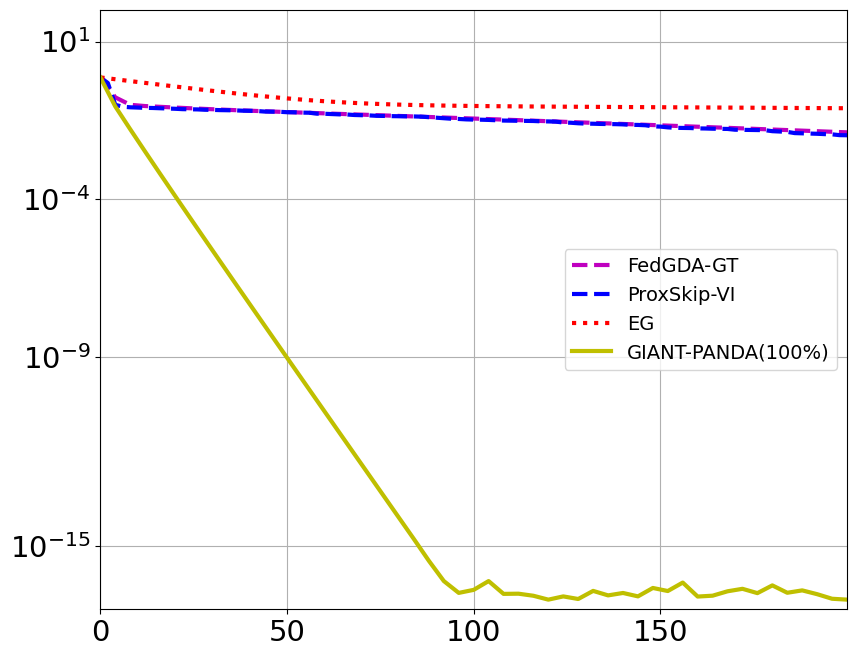

In [277]:
# high dimensional (sido0) dataset
plt.rc('font', size=21)
plt.figure(figsize=(9, 7))
plt.grid()
plt.yscale('log')
plt.plot(np.arange(0, 4*len(gradients_fed_4), 4), gradients_fed_4, '--m', label = 'FedGDA-GT', linewidth = 3)
plt.plot(np.arange(0, 2*len(gradients_ps_4), 2), gradients_ps_4, '--b', label = 'ProxSkip-VI', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_extragrad_4), 4), gradients_extragrad_4, ':r', label = 'EG', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_4_100_uni), 4), gradients_gp_4_100_uni, '-y', label = 'GIANT-PANDA(100%)', linewidth = 3)

plt.xlim((0, 200))
plt.xticks([0, 50, 100, 150])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=14)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("high_dim.pdf",bbox_inches="tight",dpi=600,format="pdf")

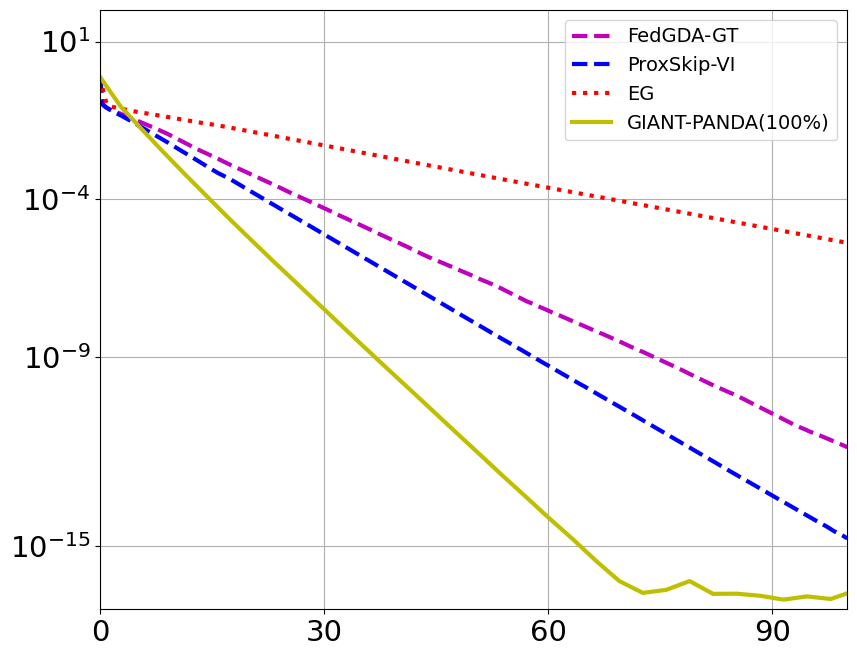

In [278]:
# high dimensional (sido0) dataset
plt.rc('font', size=21)
plt.figure(figsize=(9, 7))
plt.grid()
plt.yscale('log')
plt.plot(np.cumsum(time_fed_4), gradients_fed_4, '--m', label = 'FedGDA-GT', linewidth = 3)
plt.plot(np.cumsum(time_ps_4), gradients_ps_4, '--b', label = 'ProxSkip-VI', linewidth = 3)
plt.plot(np.cumsum(time_extragrad_4), gradients_extragrad_4, ':r', label = 'EG', linewidth = 3)
plt.plot(np.cumsum(time_gp_4_100_uni), gradients_gp_4_100_uni, '-y', label = 'GIANT-PANDA(100%)', linewidth = 3)

plt.xlim((0, 100))
plt.xticks([0, 30, 60, 90])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=14)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("high_dim_time.pdf",bbox_inches="tight",dpi=600,format="pdf")

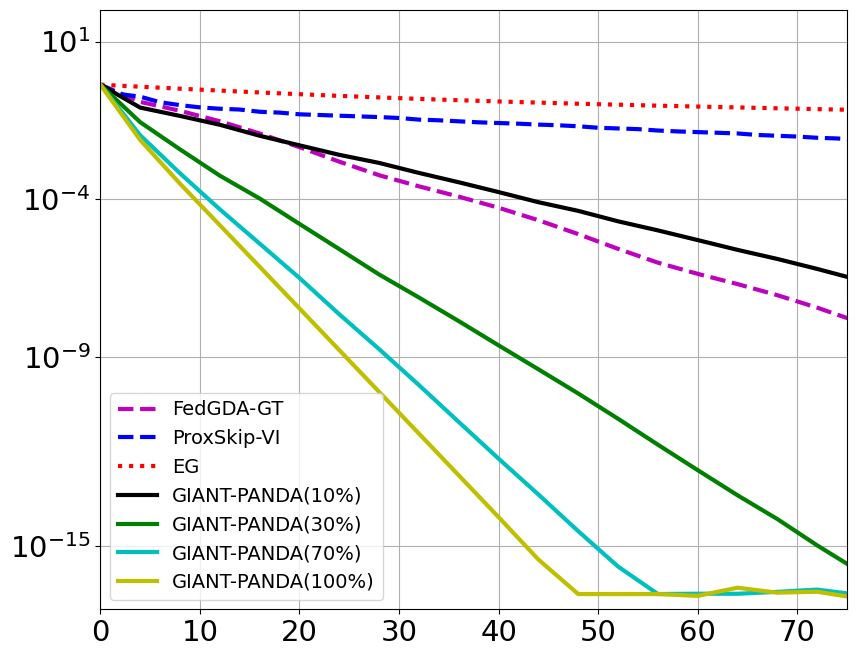

In [160]:
# PANDA vs ProxSkip vs Extragradient 128 clients, Communications
plt.rc('font', size=21)
plt.figure(figsize=(9, 7))
plt.grid()
plt.yscale('log')
plt.plot(np.arange(0, 4*len(gradients_fed_128), 4), gradients_fed_128, '--m', label = 'FedGDA-GT', linewidth = 3)
plt.plot(np.arange(0, 2*len(gradients_ps_128), 2), gradients_ps_128, '--b', label = 'ProxSkip-VI', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_extragrad_128), 4), gradients_extragrad_128, ':r', label = 'EG', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_128_10_uni), 4), gradients_gp_128_10_uni, '-k', label = 'GIANT-PANDA(10%)', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_128_30_uni), 4), gradients_gp_128_30_uni, '-g', label = 'GIANT-PANDA(30%)', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_128_70_uni), 4), gradients_gp_128_70_uni, '-c', label = 'GIANT-PANDA(70%)', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_128_100_uni), 4), gradients_gp_128_100_uni, '-y', label = 'GIANT-PANDA(100%)', linewidth = 3)

plt.xlim((0, 75))
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=14)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("gp_fed.pdf",bbox_inches="tight",dpi=600,format="pdf")

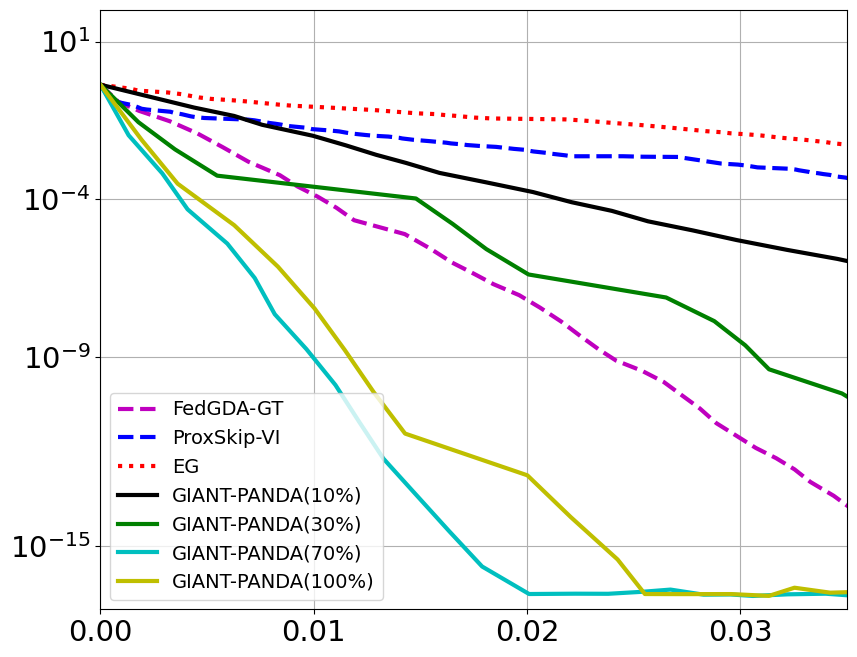

In [161]:
# PANDA vs ProxSkip vs Extragradient 128 clients, CPU Time
plt.rc('font', size=21)
plt.figure(figsize=(9, 7))
plt.grid()
plt.yscale('log')
plt.plot(np.cumsum(time_fed_128), gradients_fed_128, '--m', label = 'FedGDA-GT', linewidth = 3)
plt.plot(np.cumsum(time_ps_128), gradients_ps_128, '--b', label = 'ProxSkip-VI', linewidth = 3)
plt.plot(np.cumsum(time_extragrad_128), gradients_extragrad_128, ':r', label = 'EG', linewidth = 3)
plt.plot(np.cumsum(time_gp_128_10_uni), gradients_gp_128_10_uni, '-k', label = 'GIANT-PANDA(10%)', linewidth = 3)
plt.plot(np.cumsum(time_gp_128_30_uni), gradients_gp_128_30_uni, '-g', label = 'GIANT-PANDA(30%)', linewidth = 3)
plt.plot(np.cumsum(time_gp_128_70_uni), gradients_gp_128_70_uni, '-c', label = 'GIANT-PANDA(70%)', linewidth = 3)
plt.plot(np.cumsum(time_gp_128_100_uni), gradients_gp_128_100_uni, '-y', label = 'GIANT-PANDA(100%)', linewidth = 3)
plt.xlim((0, 0.035))
plt.xticks([0, 0.01, 0.02, 0.03])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=14)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("gp_fed_time.pdf",bbox_inches="tight",dpi=600,format="pdf")

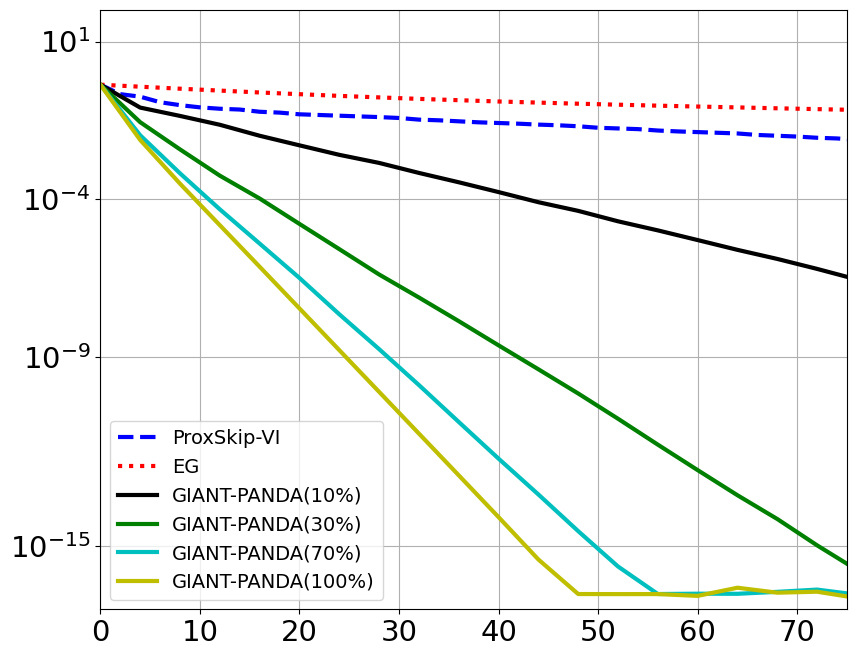

In [164]:
# PANDA vs ProxSkip vs Extragradient 128 clients, Communications
plt.rc('font', size=21)
plt.figure(figsize=(9, 7))
plt.grid()
plt.yscale('log')
plt.plot(np.arange(0, 2*len(gradients_ps_128), 2), gradients_ps_128, '--b', label = 'ProxSkip-VI', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_extragrad_128), 4), gradients_extragrad_128, ':r', label = 'EG', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_128_10_uni), 4), gradients_gp_128_10_uni, '-k', label = 'GIANT-PANDA(10%)', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_128_30_uni), 4), gradients_gp_128_30_uni, '-g', label = 'GIANT-PANDA(30%)', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_128_70_uni), 4), gradients_gp_128_70_uni, '-c', label = 'GIANT-PANDA(70%)', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_128_100_uni), 4), gradients_gp_128_100_uni, '-y', label = 'GIANT-PANDA(100%)', linewidth = 3)

plt.xlim((0, 75))
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=14)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("gp_baseline.pdf",bbox_inches="tight",dpi=600,format="pdf")

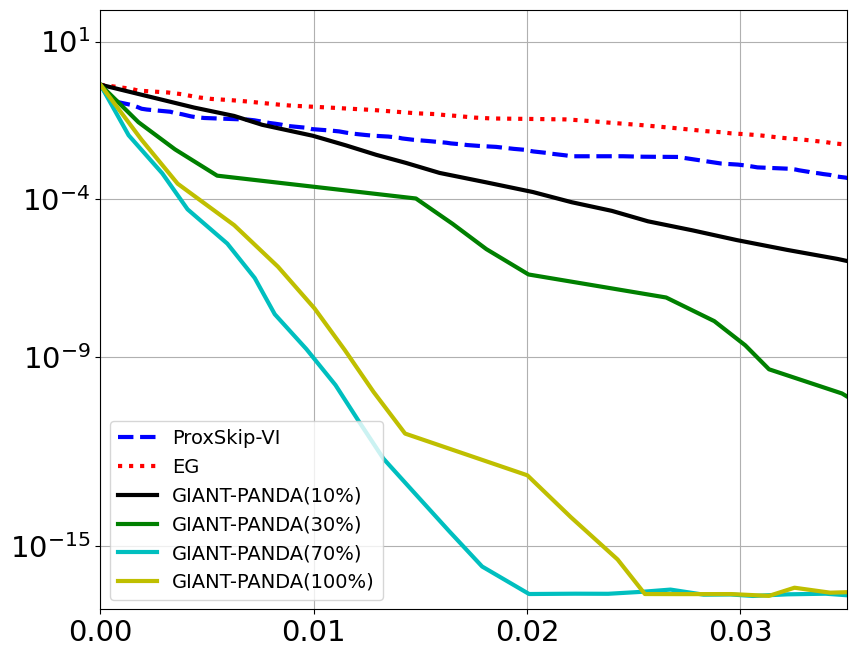

In [165]:
# PANDA vs ProxSkip vs Extragradient 128 clients, CPU Time
plt.rc('font', size=21)
plt.figure(figsize=(9, 7))
plt.grid()
plt.yscale('log')
plt.plot(np.cumsum(time_ps_128), gradients_ps_128, '--b', label = 'ProxSkip-VI', linewidth = 3)
plt.plot(np.cumsum(time_extragrad_128), gradients_extragrad_128, ':r', label = 'EG', linewidth = 3)
plt.plot(np.cumsum(time_gp_128_10_uni), gradients_gp_128_10_uni, '-k', label = 'GIANT-PANDA(10%)', linewidth = 3)
plt.plot(np.cumsum(time_gp_128_30_uni), gradients_gp_128_30_uni, '-g', label = 'GIANT-PANDA(30%)', linewidth = 3)
plt.plot(np.cumsum(time_gp_128_70_uni), gradients_gp_128_70_uni, '-c', label = 'GIANT-PANDA(70%)', linewidth = 3)
plt.plot(np.cumsum(time_gp_128_100_uni), gradients_gp_128_100_uni, '-y', label = 'GIANT-PANDA(100%)', linewidth = 3)
plt.xlim((0, 0.035))
plt.xticks([0, 0.01, 0.02, 0.03])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=14)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("gp_baseline_time.pdf",bbox_inches="tight",dpi=600,format="pdf")

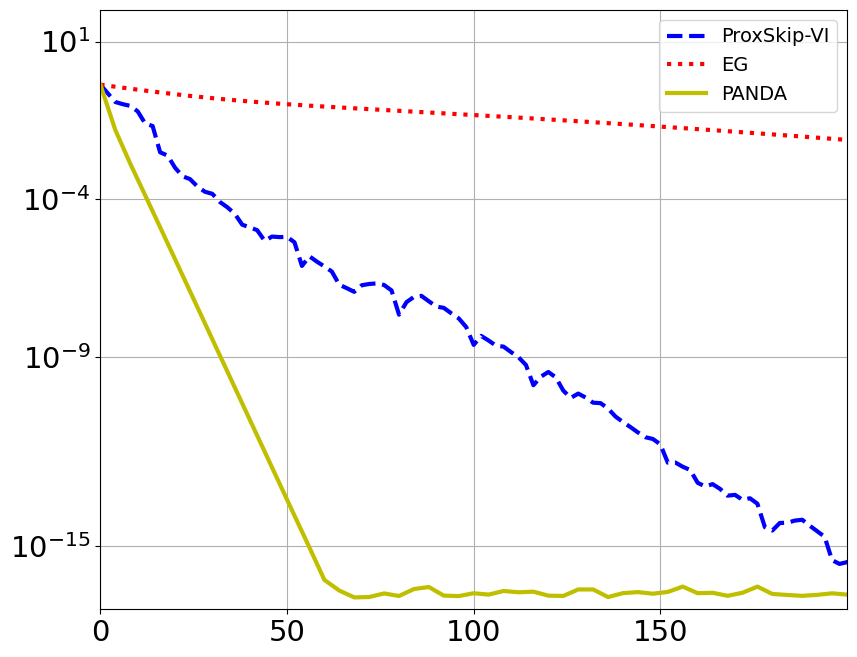

In [191]:
# PANDA vs ProxSkip vs Extragradient 256 clients, Communications
plt.rc('font', size=21)
plt.figure(figsize=(9, 7))
plt.grid()
plt.yscale('log')
plt.plot(np.arange(0, 2*len(gradients_ps_256), 2), gradients_ps_256, '--b', label = 'ProxSkip-VI', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_extragrad_256), 4), gradients_extragrad_256, ':r', label = 'EG', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_256_100_uni), 4), gradients_gp_256_100_uni, '-y', label = 'PANDA', linewidth = 3)

plt.xlim((0, 200))
plt.xticks([0, 50, 100, 150])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=14)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("256high_dist.pdf",bbox_inches="tight",dpi=600,format="pdf")

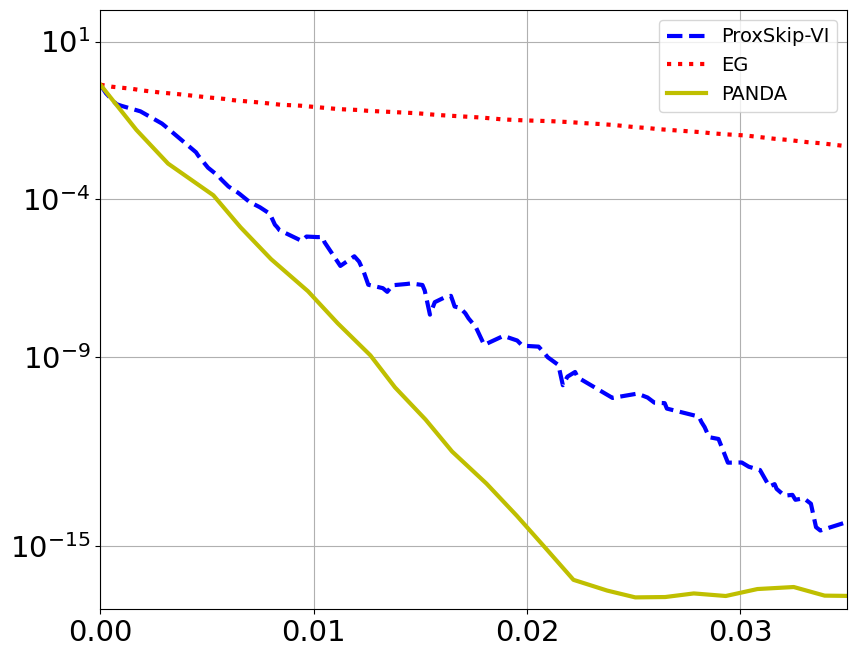

In [192]:
# PANDA vs ProxSkip vs Extragradient 1024 clients, CPU Time
plt.rc('font', size=21)
plt.figure(figsize=(9, 7))
plt.grid()
plt.yscale('log')
plt.plot(np.cumsum(time_ps_256), gradients_ps_256, '--b', label = 'ProxSkip-VI', linewidth = 3)
plt.plot(np.cumsum(time_extragrad_256), gradients_extragrad_256, ':r', label = 'EG', linewidth = 3)
plt.plot(np.cumsum(time_gp_256_100_uni), gradients_gp_256_100_uni, '-y', label = 'PANDA', linewidth = 3)
plt.xlim((0, 0.035))
plt.xticks([0, 0.01, 0.02, 0.03])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=14)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("256high_dist_time.pdf",bbox_inches="tight",dpi=600,format="pdf")

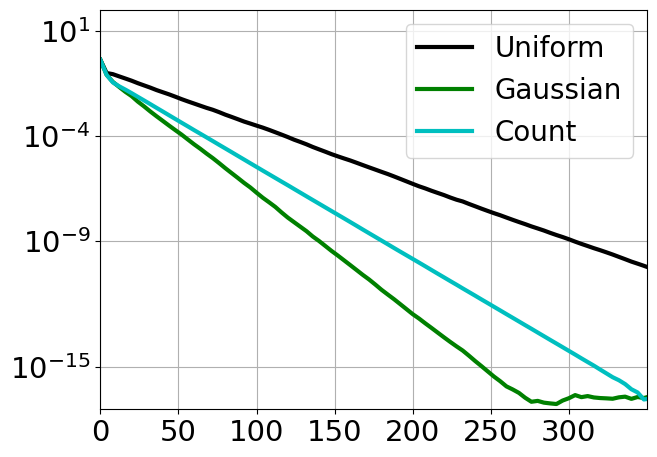

In [166]:
# On 1024 nodes, with 30% sketch percentage, using different sketch methods
# Communication
plt.rc('font', size=21)
plt.figure(figsize=(7, 5))
plt.grid()
plt.yscale('log')
plt.plot(np.arange(0, 4*len(gradients_gp_1024_30_uni), 4), gradients_gp_1024_30_uni, '-k', label = 'Uniform', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_1024_30_gauss), 4), gradients_gp_1024_30_gauss, '-g', label = 'Gaussian', linewidth = 3)
plt.plot(np.arange(0, 4*len(gradients_gp_1024_30_count), 4), gradients_gp_1024_30_count, '-c', label = 'Count', linewidth = 3)
plt.xlim((0, 350))
plt.xticks([0, 50, 100, 150, 200, 250, 300])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=20)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("different_sketch.pdf",bbox_inches="tight",dpi=600,format="pdf")

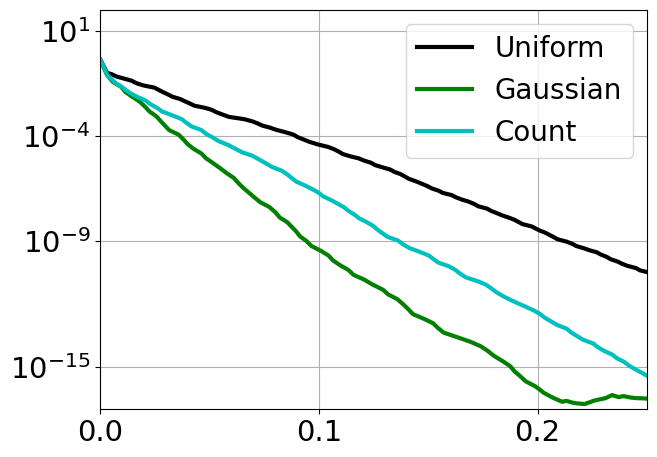

In [167]:
# On 1024 nodes, with 30% sketch percentage, using different sketch methods
# Communication
plt.rc('font', size=21)
plt.figure(figsize=(7, 5))
plt.grid()
plt.yscale('log')
plt.plot(np.cumsum(time_gp_1024_30_uni), gradients_gp_1024_30_uni, '-k', label = 'Uniform', linewidth = 3)
plt.plot(np.cumsum(time_gp_1024_30_gauss), gradients_gp_1024_30_gauss, '-g', label = 'Gaussian', linewidth = 3)
plt.plot(np.cumsum(time_gp_1024_30_count), gradients_gp_1024_30_count, '-c', label = 'Count', linewidth = 3)
plt.xlim((0, 0.25))
plt.xticks([0, 0.1, 0.2])
plt.ylim([1e-17,1e2])
plt.yticks([1e-15,1e-9,1e-4,1e1])
plt.legend(fontsize=20)
plt.tick_params('x', labelsize=21)
plt.tick_params('y', labelsize=21)
plt.tight_layout()
plt.savefig("different_sketch_time.pdf",bbox_inches="tight",dpi=600,format="pdf")

# Part XI: w8a Dataset

In [73]:
m = loadmat('w8a.mat')
A0 = np.array(m['A']).astype("float")
b1 = np.array(m['b']).astype("float")
b1[np.where(b1 == -1)[0]] = 0
A1 = np.hstack((A0, b1))

In [74]:
A1.shape

(45546, 301)

## Part XI-I: PAN Solution

In [12]:
# PAN(5%)
params = np.zeros(303).reshape(-1, 1)
params_pan_5, gradients_pan_5, time_pan_5 = PAN(params, A1, 0.5, ratio=0.05, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.05312658801153159
epoch 5, gradient norm: 3.7086888410322146e-08
epoch 10, gradient norm: 5.157475126254869e-13
epoch 15, gradient norm: 1.1695311912906721e-17
epoch 20, gradient norm: 4.466905590533711e-18
epoch 25, gradient norm: 4.560999294799349e-18
epoch 30, gradient norm: 4.529622814665258e-18
epoch 35, gradient norm: 4.540334290669421e-18
epoch 40, gradient norm: 4.466905590533711e-18
epoch 45, gradient norm: 4.560999294799349e-18
epoch 50, gradient norm: 4.529622814665258e-18
epoch 55, gradient norm: 4.540334290669421e-18
epoch 60, gradient norm: 4.466905590533711e-18
epoch 65, gradient norm: 4.560999294799349e-18
epoch 70, gradient norm: 4.529622814665258e-18
epoch 75, gradient norm: 4.540334290669421e-18
epoch 80, gradient norm: 4.466905590533711e-18
epoch 85, gradient norm: 4.560999294799349e-18
epoch 90, gradient norm: 4.529622814665258e-18
epoch 95, gradient norm: 4.540334290669421e-18
epoch 100, gradient norm: 4.466905590533711e-18


In [13]:
# PAN(10%)
params = np.zeros(303).reshape(-1, 1)
params_pan_10, gradients_pan_10, time_pan_10 = PAN(params, A1, 0.5, ratio=0.1, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.05312658801153159
epoch 5, gradient norm: 3.1337181714061407e-10
epoch 10, gradient norm: 3.3204919726333827e-17
epoch 15, gradient norm: 3.748646680813994e-18
epoch 20, gradient norm: 3.872042203738242e-18
epoch 25, gradient norm: 4.061696712863742e-18
epoch 30, gradient norm: 3.742364970555301e-18
epoch 35, gradient norm: 3.736083740570408e-18
epoch 40, gradient norm: 4.055899878269894e-18
epoch 45, gradient norm: 3.748646680813994e-18
epoch 50, gradient norm: 3.872042203738242e-18
epoch 55, gradient norm: 4.061696712863742e-18
epoch 60, gradient norm: 3.742364970555301e-18
epoch 65, gradient norm: 3.736083740570408e-18
epoch 70, gradient norm: 4.055899878269894e-18
epoch 75, gradient norm: 3.748646680813994e-18
epoch 80, gradient norm: 3.872042203738242e-18
epoch 85, gradient norm: 4.061696712863742e-18
epoch 90, gradient norm: 3.742364970555301e-18
epoch 95, gradient norm: 3.736083740570408e-18
epoch 100, gradient norm: 4.055899878269894e-18


In [14]:
# PAN(20%)
params = np.zeros(303).reshape(-1, 1)
params_pan_20, gradients_pan_20, time_pan_20 = PAN(params, A1, 0.5, ratio=0.2, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.05312658801153159
epoch 5, gradient norm: 4.846236785209945e-10
epoch 10, gradient norm: 3.194621085828048e-17
epoch 15, gradient norm: 4.296302852990588e-18
epoch 20, gradient norm: 4.404791329909431e-18
epoch 25, gradient norm: 4.296302852990588e-18
epoch 30, gradient norm: 4.318549556913644e-18
epoch 35, gradient norm: 4.296302852990588e-18
epoch 40, gradient norm: 4.404791329909431e-18
epoch 45, gradient norm: 4.296302852990588e-18
epoch 50, gradient norm: 4.318549556913644e-18
epoch 55, gradient norm: 4.296302852990588e-18
epoch 60, gradient norm: 4.404791329909431e-18
epoch 65, gradient norm: 4.296302852990588e-18
epoch 70, gradient norm: 4.318549556913644e-18
epoch 75, gradient norm: 4.296302852990588e-18
epoch 80, gradient norm: 4.404791329909431e-18
epoch 85, gradient norm: 4.296302852990588e-18
epoch 90, gradient norm: 4.318549556913644e-18
epoch 95, gradient norm: 4.296302852990588e-18
epoch 100, gradient norm: 4.404791329909431e-18


## Part XI-II: PANDA Solution

In [25]:
# PANDA(4)
params = np.zeros(303).reshape(-1, 1)
params_panda_4, gradients_panda_4, time_panda_4 = PANDA(params, A1, 0.5, n_workers=4, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.05311838824991995
epoch 5, gradient norm: 1.1665497904876212e-17
epoch 10, gradient norm: 3.726304633005091e-18
epoch 15, gradient norm: 3.96401609538561e-18
epoch 20, gradient norm: 3.3054559730482118e-18
epoch 25, gradient norm: 3.333811925841645e-18
epoch 30, gradient norm: 3.743369322765588e-18
epoch 35, gradient norm: 3.96230134530992e-18
epoch 40, gradient norm: 2.9711583218573726e-18
epoch 45, gradient norm: 3.936513790216716e-18
epoch 50, gradient norm: 3.176962580769108e-18
epoch 55, gradient norm: 3.865839441038094e-18
epoch 60, gradient norm: 3.6377874960236194e-18
epoch 65, gradient norm: 3.4042754694678856e-18
epoch 70, gradient norm: 3.786955762864303e-18
epoch 75, gradient norm: 3.910861466862264e-18
epoch 80, gradient norm: 3.164740444467724e-18
epoch 85, gradient norm: 3.631142023557697e-18
epoch 90, gradient norm: 3.621290430114073e-18
epoch 95, gradient norm: 3.563387374625451e-18
epoch 100, gradient norm: 3.1322472117330973e-18


In [26]:
# PANDA(8)
params = np.zeros(303).reshape(-1, 1)
params_panda_8, gradients_panda_8, time_panda_8 = PANDA(params, A1, 0.5, n_workers=8, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.053113411400999344
epoch 5, gradient norm: 4.473397916878276e-17
epoch 10, gradient norm: 2.4942196495440516e-18
epoch 15, gradient norm: 2.6190521713432465e-18
epoch 20, gradient norm: 2.456040351679612e-18
epoch 25, gradient norm: 2.6190521713432465e-18
epoch 30, gradient norm: 2.456040351679612e-18
epoch 35, gradient norm: 2.6190521713432465e-18
epoch 40, gradient norm: 2.456040351679612e-18
epoch 45, gradient norm: 2.6190521713432465e-18
epoch 50, gradient norm: 2.456040351679612e-18
epoch 55, gradient norm: 2.6190521713432465e-18
epoch 60, gradient norm: 2.456040351679612e-18
epoch 65, gradient norm: 2.6190521713432465e-18
epoch 70, gradient norm: 2.456040351679612e-18
epoch 75, gradient norm: 2.6190521713432465e-18
epoch 80, gradient norm: 2.456040351679612e-18
epoch 85, gradient norm: 2.6190521713432465e-18
epoch 90, gradient norm: 2.456040351679612e-18
epoch 95, gradient norm: 2.6190521713432465e-18
epoch 100, gradient norm: 2.456040351679612e-18


In [27]:
# PANDA(16)
params = np.zeros(303).reshape(-1, 1)
params_panda_16, gradients_panda_16, time_panda_16 = PANDA(params, A1, 0.5, n_workers=16, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.053053425507911034
epoch 5, gradient norm: 8.214559564911885e-15
epoch 10, gradient norm: 2.4440499144097166e-18
epoch 15, gradient norm: 2.410552276824625e-18
epoch 20, gradient norm: 2.45267696861181e-18
epoch 25, gradient norm: 2.410552276824625e-18
epoch 30, gradient norm: 2.45267696861181e-18
epoch 35, gradient norm: 2.410552276824625e-18
epoch 40, gradient norm: 2.45267696861181e-18
epoch 45, gradient norm: 2.410552276824625e-18
epoch 50, gradient norm: 2.45267696861181e-18
epoch 55, gradient norm: 2.410552276824625e-18
epoch 60, gradient norm: 2.45267696861181e-18
epoch 65, gradient norm: 2.410552276824625e-18
epoch 70, gradient norm: 2.45267696861181e-18
epoch 75, gradient norm: 2.410552276824625e-18
epoch 80, gradient norm: 2.45267696861181e-18
epoch 85, gradient norm: 2.410552276824625e-18
epoch 90, gradient norm: 2.45267696861181e-18
epoch 95, gradient norm: 2.410552276824625e-18
epoch 100, gradient norm: 2.45267696861181e-18


In [28]:
# PANDA(32)
params = np.zeros(303).reshape(-1, 1)
params_panda_32, gradients_panda_32, time_panda_32 = PANDA(params, A1, 0.5, n_workers=32, epochs=100, lr=1.0)

epoch 0, gradient norm: 0.05307906904828526
epoch 5, gradient norm: 1.6141622351808046e-13
epoch 10, gradient norm: 2.257498896242792e-18
epoch 15, gradient norm: 2.5356713641171032e-18
epoch 20, gradient norm: 2.3943964823405948e-18
epoch 25, gradient norm: 2.2685198456807654e-18
epoch 30, gradient norm: 2.3500558188734792e-18
epoch 35, gradient norm: 2.5356713641171032e-18
epoch 40, gradient norm: 2.3943964823405948e-18
epoch 45, gradient norm: 2.2685198456807654e-18
epoch 50, gradient norm: 2.3500558188734792e-18
epoch 55, gradient norm: 2.5356713641171032e-18
epoch 60, gradient norm: 2.3943964823405948e-18
epoch 65, gradient norm: 2.2685198456807654e-18
epoch 70, gradient norm: 2.3500558188734792e-18
epoch 75, gradient norm: 2.5356713641171032e-18
epoch 80, gradient norm: 2.3943964823405948e-18
epoch 85, gradient norm: 2.2685198456807654e-18
epoch 90, gradient norm: 2.3500558188734792e-18
epoch 95, gradient norm: 2.5356713641171032e-18
epoch 100, gradient norm: 2.3943964823405948e-

## Part XI-III: EG Solution

In [32]:
# EG(8)
params = np.zeros(303).reshape(-1, 1)
params_extragrad_8, gradients_extragrad_8, time_extragrad_8 = parallel_extra(params, A1, 0.5, n_workers=8, epochs=500, lr=1.0)

epoch 0, gradient norm: 0.05311543934296598
epoch 20, gradient norm: 0.0016890193301069545
epoch 40, gradient norm: 0.0005121445395638965
epoch 60, gradient norm: 0.00015532506837980165
epoch 80, gradient norm: 4.7063071414439934e-05
epoch 100, gradient norm: 1.4259314578943253e-05
epoch 120, gradient norm: 4.3203205125994205e-06
epoch 140, gradient norm: 1.3089806495652559e-06
epoch 160, gradient norm: 3.9659796619933896e-07
epoch 180, gradient norm: 1.2016216342474975e-07
epoch 200, gradient norm: 3.6407008478986225e-08
epoch 220, gradient norm: 1.1030679114251354e-08
epoch 240, gradient norm: 3.3421005140569345e-09
epoch 260, gradient norm: 1.0125972973628592e-09
epoch 280, gradient norm: 3.067990568129793e-10
epoch 300, gradient norm: 9.29546829318317e-11
epoch 320, gradient norm: 2.8163624392384376e-11
epoch 340, gradient norm: 8.533078702436328e-12
epoch 360, gradient norm: 2.5853706716786314e-12
epoch 380, gradient norm: 7.833226698268007e-13
epoch 400, gradient norm: 2.37331875

## Part XI-IV: ProxSkip-VI Solution

In [252]:
# proxskip(8)
params = np.zeros(303).reshape(-1, 1)
controls = np.zeros(303).reshape(-1, 1)
params_ps_8, gradients_ps_8, time_ps_8 = proxskip(params, controls, A1, 0.5, n_workers=8, epochs=500, lr=1.0, prob=0.4)

epoch 0, gradient norm: 0.0531299309424145
epoch 1, gradient norm: 0.02253365906274773
epoch 2, gradient norm: 0.010662967793575198
epoch 7, gradient norm: 0.003522215323523237
epoch 8, gradient norm: 0.003315430175341179
epoch 9, gradient norm: 0.0031197116335516476
epoch 14, gradient norm: 0.002275216386846674
epoch 15, gradient norm: 0.00213464967359798
epoch 16, gradient norm: 0.0020028388538140397
epoch 17, gradient norm: 0.0018791517493914418
epoch 20, gradient norm: 0.001552125292282849
epoch 21, gradient norm: 0.0014562478966378407
epoch 22, gradient norm: 0.0013662779596788504
epoch 23, gradient norm: 0.0012818674784972133
epoch 24, gradient norm: 0.001202674149367692
epoch 26, gradient norm: 0.0010587009369483185
epoch 27, gradient norm: 0.0009933022535358195
epoch 36, gradient norm: 0.0005602344112680787
epoch 41, gradient norm: 0.00040747769041359674
epoch 43, gradient norm: 0.0003587084645354386
epoch 44, gradient norm: 0.0003365449170318353
epoch 45, gradient norm: 0.0003

epoch 423, gradient norm: 1.0964104535343402e-14
epoch 426, gradient norm: 9.057255358933424e-15
epoch 429, gradient norm: 7.481242884567584e-15
epoch 434, gradient norm: 5.440276185089821e-15
epoch 438, gradient norm: 4.215768067160291e-15
epoch 439, gradient norm: 3.9557970187631125e-15
epoch 440, gradient norm: 3.710328293108193e-15
epoch 443, gradient norm: 3.0644430370962417e-15
epoch 447, gradient norm: 2.3743671100760956e-15
epoch 449, gradient norm: 2.090269792852338e-15
epoch 457, gradient norm: 1.2546137808842829e-15
epoch 461, gradient norm: 9.724853757014612e-16
epoch 464, gradient norm: 8.040589649110282e-16
epoch 473, gradient norm: 4.539163764755716e-16
epoch 476, gradient norm: 3.7500037043889584e-16
epoch 477, gradient norm: 3.51376986889269e-16
epoch 480, gradient norm: 2.9006229502836513e-16
epoch 484, gradient norm: 2.2497010343531374e-16
epoch 487, gradient norm: 1.8493878629000301e-16
epoch 489, gradient norm: 1.6339514964346277e-16
epoch 490, gradient norm: 1.527